In [1]:
import glob
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import geometry_mask
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import joblib

In [2]:
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels
features = []
labels = []
image_names = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_names.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_names = np.hstack(image_names)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_names
})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [5]:
# Add island column
dataset['island'] = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0])

# Function to print class distribution
def print_class_distribution(df, name):
    class_counts = df['labels'].value_counts()
    print(f"\n{name} Class Distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

def train_evaluate_island_model(island_data, island_name):
    X = island_data.drop(columns=['labels', 'encoded_labels', 'image_name', 'island'])
    y = island_data['encoded_labels']
    
    # Get the unique labels for this island
    island_labels = island_data['labels'].unique()
    island_label_encoder = LabelEncoder().fit(island_labels)
    y = island_label_encoder.transform(island_data['labels'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, f"RF_{island_name}.joblib")
    
    y_pred = model.predict(X_test)
    
    print(f"\nResults for {island_name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=island_labels))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=island_labels, yticklabels=island_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {island_name}')
    plt.show()
    
    return model, island_label_encoder



Training data for buch Class Distribution:
ocean: 313885
ice: 195822
freshwater: 34517
rock: 9291
walrus_mixed: 190

Results for buch:
Accuracy: 0.9823
Precision: 0.9821
Recall: 0.9823
F1 Score: 0.9819
Cohen's Kappa: 0.9677

Classification Report:
              precision    recall  f1-score   support

walrus_mixed       0.90      0.88      0.89      6903
       ocean       0.97      0.99      0.98     39165
        rock       1.00      1.00      1.00     62777
  freshwater       0.93      0.81      0.87      1858
         ice       1.00      0.03      0.05        38

    accuracy                           0.98    110741
   macro avg       0.96      0.74      0.76    110741
weighted avg       0.98      0.98      0.98    110741


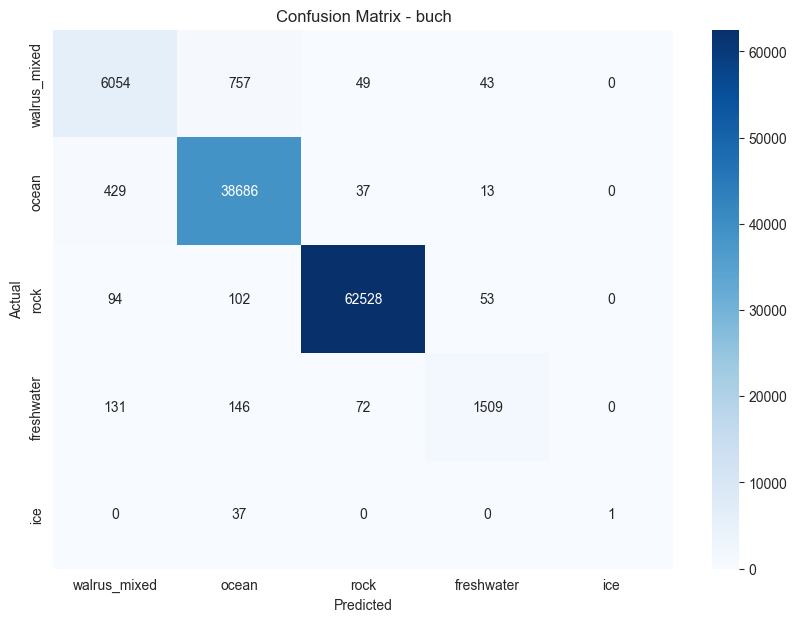


Training data for moff Class Distribution:
ocean: 55129
ice: 12090
freshwater: 244
walrus_mixed: 44

Results for moff:
Accuracy: 0.9987
Precision: 0.9987
Recall: 0.9987
F1 Score: 0.9986
Cohen's Kappa: 0.9958

Classification Report:
              precision    recall  f1-score   support

walrus_mixed       0.97      0.80      0.88        49
       ocean       0.99      1.00      1.00      2418
         ice       1.00      1.00      1.00     11026
  freshwater       1.00      0.44      0.62         9

    accuracy                           1.00     13502
   macro avg       0.99      0.81      0.87     13502
weighted avg       1.00      1.00      1.00     13502


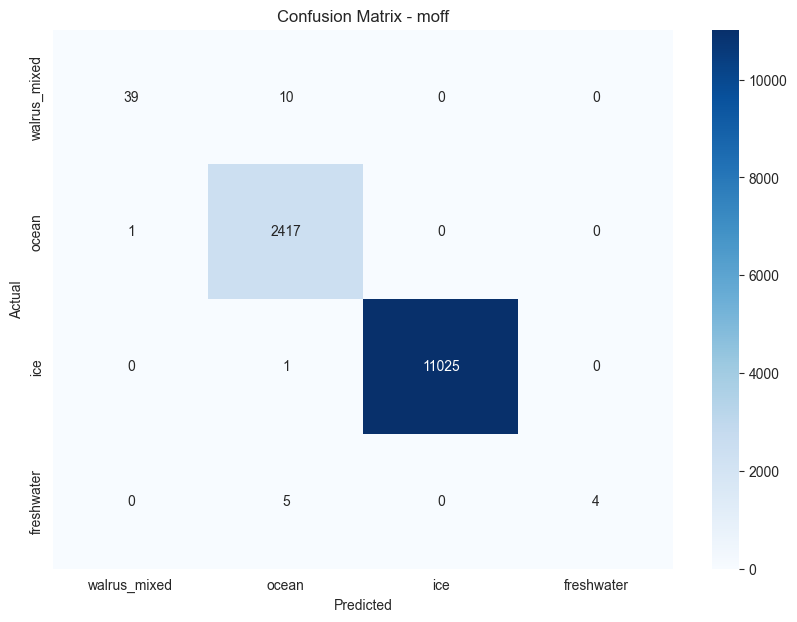


Training data for pal Class Distribution:
rock: 82490
ocean: 77962
ice: 9788
walrus_mixed: 234

Results for pal:
Accuracy: 0.9955
Precision: 0.9955
Recall: 0.9955
F1 Score: 0.9951
Cohen's Kappa: 0.9918

Classification Report:
              precision    recall  f1-score   support

walrus_mixed       1.00      0.96      0.98      1958
       ocean       1.00      1.00      1.00     15592
        rock       0.99      1.00      1.00     16498
         ice       1.00      0.21      0.35        47

    accuracy                           1.00     34095
   macro avg       1.00      0.79      0.83     34095
weighted avg       1.00      1.00      1.00     34095


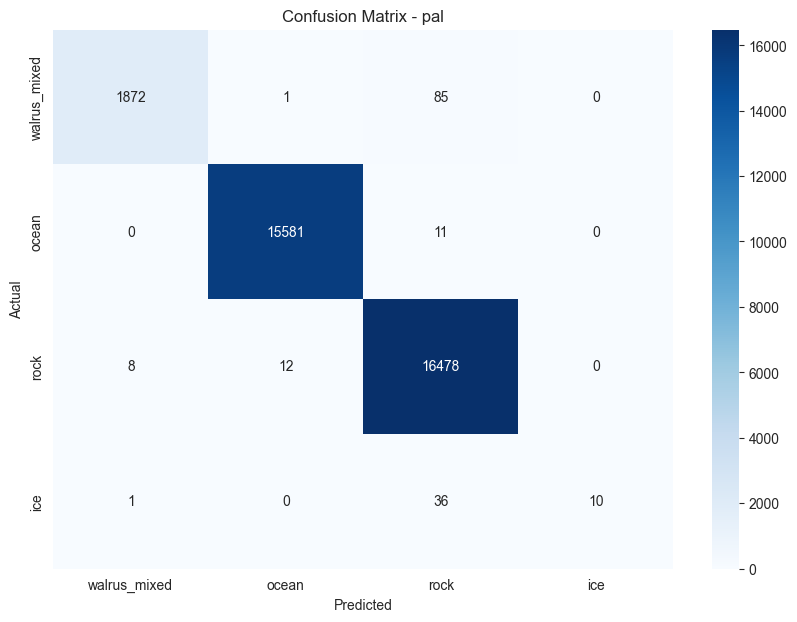


Training data for sars Class Distribution:
ocean: 143231
ice: 5789
walrus_mixed: 131

Results for sars:
Accuracy: 0.9990
Precision: 0.9990
Recall: 0.9990
F1 Score: 0.9989
Cohen's Kappa: 0.9868

Classification Report:
              precision    recall  f1-score   support

walrus_mixed       0.98      0.99      0.99      1158
       ocean       1.00      1.00      1.00     28647
         ice       1.00      0.46      0.63        26

    accuracy                           1.00     29831
   macro avg       0.99      0.82      0.87     29831
weighted avg       1.00      1.00      1.00     29831


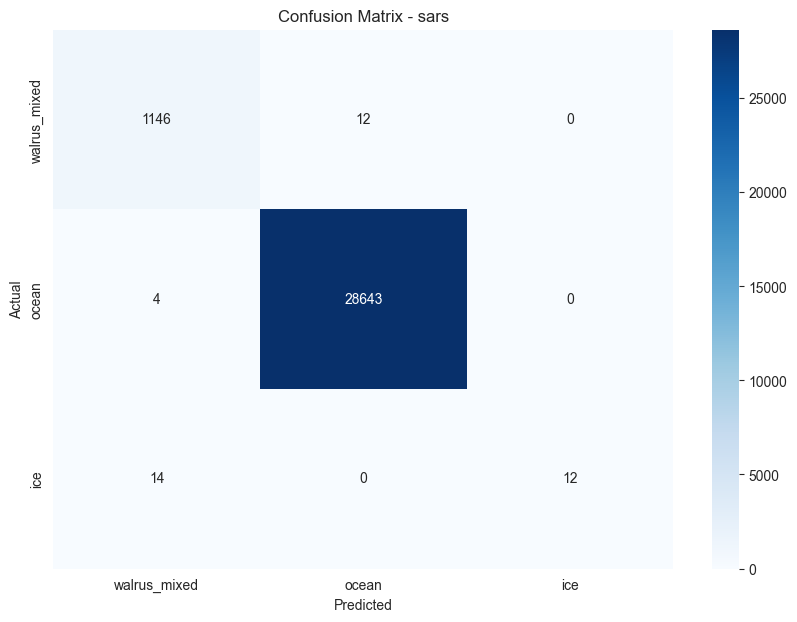


Training data for tor Class Distribution:
ocean: 189081
ice: 76742
freshwater: 5490
rock: 1075
walrus_mixed: 223
walrus_pure: 48

Results for tor:
Accuracy: 0.9952
Precision: 0.9947
Recall: 0.9952
F1 Score: 0.9946
Cohen's Kappa: 0.9890

Classification Report:
              precision    recall  f1-score   support

walrus_mixed       0.98      0.95      0.96      1098
       ocean       0.99      1.00      0.99     15348
         ice       1.00      1.00      1.00     37816
  freshwater       0.80      0.34      0.48       215
        rock       0.89      0.73      0.80        45
 walrus_pure       0.75      0.60      0.67        10

    accuracy                           1.00     54532
   macro avg       0.90      0.77      0.82     54532
weighted avg       0.99      1.00      0.99     54532


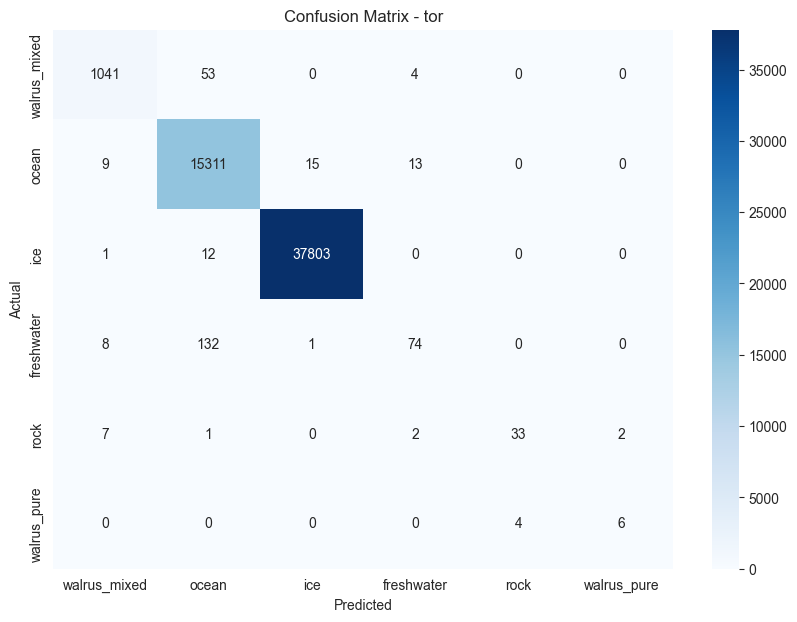

In [6]:
# Train models for each island
island_models = {}
island_encoders = {}
for island in dataset['island'].unique():
    island_data = dataset[dataset['island'] == island]
    print_class_distribution(island_data, f"Training data for {island}")
    island_models[island], island_encoders[island] = train_evaluate_island_model(island_data, island)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report

def predict_image(image_path, model, encoder):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return encoder.inverse_transform(predictions).reshape((src.height, src.width))

def plot_predictions(predicted_image, title, encoder):
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    cmap = mcolors.ListedColormap(['whitesmoke', 'cornflowerblue', 'dimgrey', 'aquamarine', 'mediumorchid', 'hotpink'])
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(encoder.classes_)-1)
    cbar = plt.colorbar(ticks=range(len(encoder.classes_)), label='Class')
    cbar.ax.set_yticklabels(encoder.classes_)
    present_labels = [encoder.classes_[i] for i in unique_labels]
    print(f"Labels present: {present_labels}")
    plt.show()

def evaluate_predictions(true_labels, predicted_labels, encoder):
    print(f"Accuracy: {accuracy_score(true_labels, predicted_labels):.4f}")
    print(f"Precision: {precision_score(true_labels, predicted_labels, average='weighted'):.4f}")
    print(f"Recall: {recall_score(true_labels, predicted_labels, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(true_labels, predicted_labels, average='weighted'):.4f}")
    print(f"Cohen's Kappa: {cohen_kappa_score(true_labels, predicted_labels):.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=encoder.classes_))

# Predict and plot for each island
for island, model in island_models.items():
    encoder = island_encoders[island]
    print(f"\n--- Predictions for {island} ---")
    
    # Predict on training images
    print("\nTraining Images:")
    island_train_images = [img for img in image_paths if island in img]
    for image_path in island_train_images:
        predicted_image = predict_image(image_path, model, encoder)
        plot_predictions(predicted_image, f"{island} Model Prediction on Training Image", encoder)
    
    # Predict on unseen images
    print("\nUnseen Images:")
    island_unseen_images = [img for img in unlabeled_image_paths if island in img]
    for image_path in island_unseen_images:
        predicted_image = predict_image(image_path, model, encoder)
        plot_predictions(predicted_image, f"{island} Model Prediction on Unseen Image", encoder)

# Cross-island prediction
source_island = list(island_models.keys())[0]  # Choose the first island as source
target_island = list(island_models.keys())[1]  # Choose the second island as target

print(f"\n--- Cross-island Prediction: {source_island} Model on {target_island} Data ---")

# Predict on target island's training images
print("\nTarget Island Training Images:")
target_train_images = [img for img in image_paths if target_island in img]
for image_path in target_train_images:
    predicted_image = predict_image(image_path, island_models[source_island], island_encoders[source_island])
    plot_predictions(predicted_image, f"{source_island} Model Prediction on {target_island} Training Image", island_encoders[source_island])

# Predict on target island's unseen images
print("\nTarget Island Unseen Images:")
target_unseen_images = [img for img in unlabeled_image_paths if target_island in img]
for image_path in target_unseen_images:
    predicted_image = predict_image(image_path, island_models[source_island], island_encoders[source_island])
    plot_predictions(predicted_image, f"{source_island} Model Prediction on {target_island} Unseen Image", island_encoders[source_island])

# Evaluate cross-island prediction on target island's training data
target_train_data = dataset[dataset['island'] == target_island]
X_target = target_train_data.drop(columns=['labels', 'encoded_labels', 'image_name', 'island'])
y_true = target_train_data['labels']
y_pred = island_models[source_island].predict(X_target)
y_pred = island_encoders[source_island].inverse_transform(y_pred)

print(f"\nMetrics for {source_island} Model on {target_island} Training Data:")
evaluate_predictions(y_true, y_pred, island_encoders[source_island])

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


TypeError: Image data of dtype object cannot be converted to float

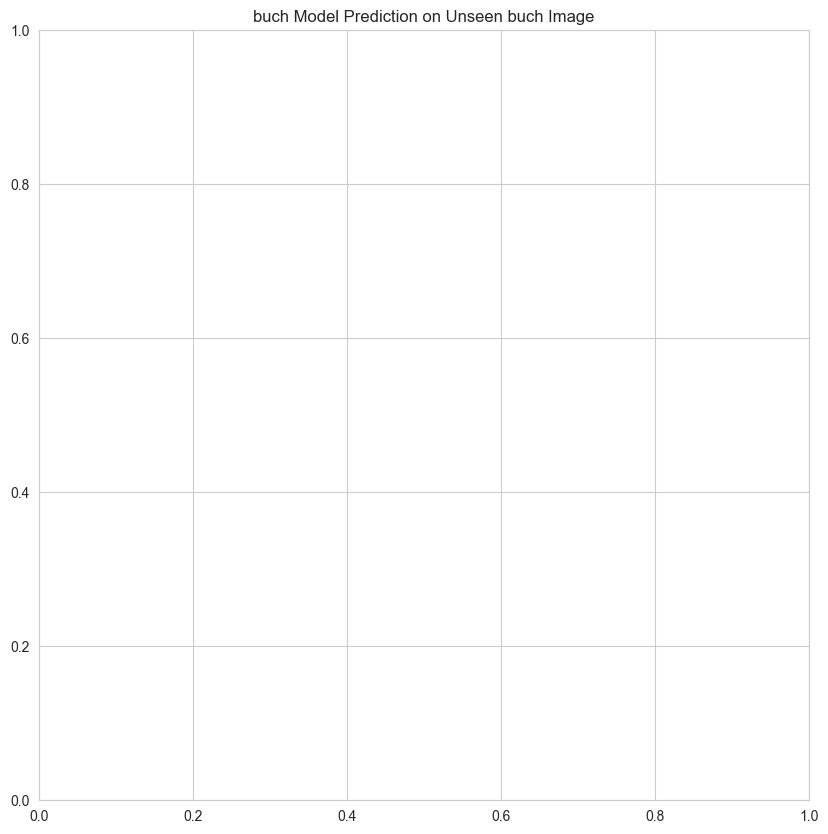

In [7]:
def predict_image(image_path, model, encoder):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return encoder.inverse_transform(predictions).reshape((src.height, src.width))
    
# Function to plot predictions
def plot_predictions(predicted_image, title):
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    cmap = mcolors.ListedColormap(['whitesmoke', 'cornflowerblue', 'dimgrey', 'aquamarine', 'mediumorchid', 'hotpink'])
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present: {present_labels}")
    plt.show()    

# Predict on unseen images from the same island
for island, model in island_models.items():
    encoder = island_encoders[island]
    island_unseen_images = [img for img in unlabeled_image_paths if island in img]
    for image_path in island_unseen_images:
        predicted_image = predict_image(image_path, model, encoder)
        plot_predictions(predicted_image, f"{island} Model Prediction on Unseen {island} Image")

# Example: Predict using one island's model on a different island's image
source_island = list(island_models.keys())[0]  # Choose the first island as source
target_island = list(island_models.keys())[1]  # Choose the second island as target

target_image = [img for img in unlabeled_image_paths if target_island in img][0]  # Choose the first image of target island
predicted_image = predict_image(target_image, island_models[source_island], island_encoders[source_island])
plot_predictions(predicted_image, f"{source_island} Model Prediction on {target_island} Image")

In [ ]:
# Function to predict image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))



# Predict on unseen images from the same island
for island, model in island_models.items():
    island_unseen_images = [img for img in unlabeled_image_paths if island in img]
    for image_path in island_unseen_images:
        predicted_image = predict_image(image_path, model)
        plot_predictions(predicted_image, f"{island} Model Prediction on Unseen {island} Image")

In [ ]:
# Example: Predict using one island's model on a different island's image
source_island = list(island_models.keys())[0]  # Choose the first island as source
target_island = list(island_models.keys())[1]  # Choose the second island as target

target_image = [img for img in unlabeled_image_paths if target_island in img][0]  # Choose the first image of target island
predicted_image = predict_image(target_image, island_models[source_island])
plot_predictions(predicted_image, f"{source_island} Model Prediction on {target_island} Image")

BUCH 

In [1]:
import os
import glob
import re
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import joblib

In [5]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\buch_image"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\buch_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\buch_unseen"  

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

In [6]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

In [7]:
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path


In [8]:
# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_image\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_train\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_image\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_train\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_image\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_train\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_image\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_train\buch_20230923_train.shp


In [9]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

n_estimaters - number of nodes on the trees. 
random state - 


x test y test - validation instead. 

In [10]:
# Save the model
model_filename = "walrus_model_buch.joblib"
joblib.dump(model, model_filename)


['walrus_model_buch.joblib']

In [11]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

  freshwater       0.90      0.88      0.89      6947
         ice       0.97      0.99      0.98     39010
       ocean       1.00      1.00      1.00     62835
        rock       0.93      0.82      0.87      1913
walrus_mixed       1.00      0.03      0.05        36

    accuracy                           0.98    110741
   macro avg       0.96      0.74      0.76    110741
weighted avg       0.98      0.98      0.98    110741


In [12]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


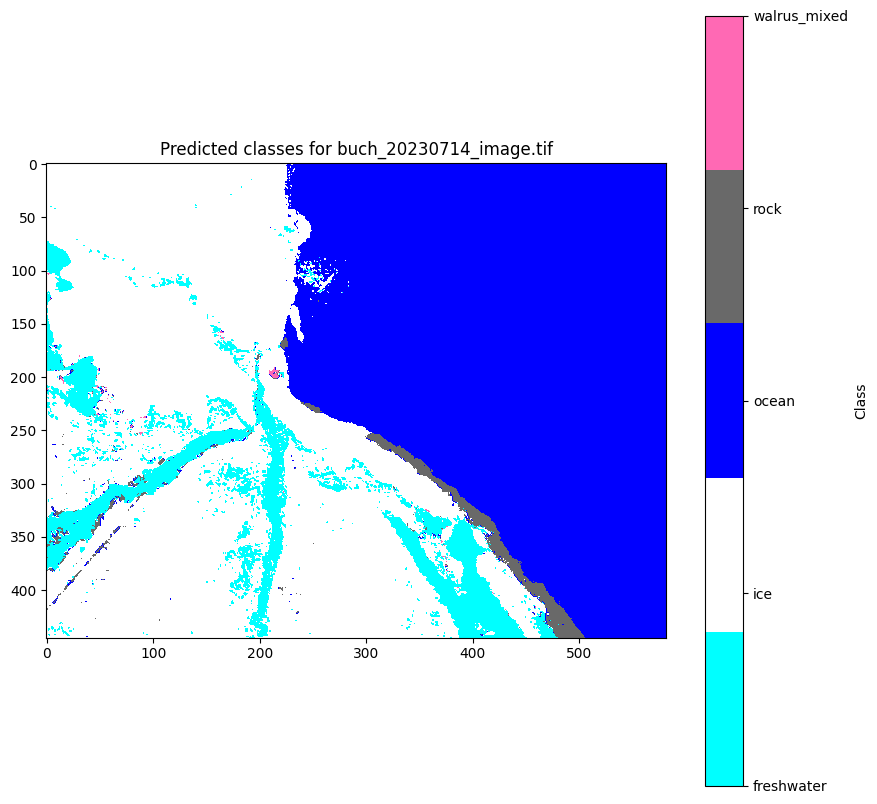

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


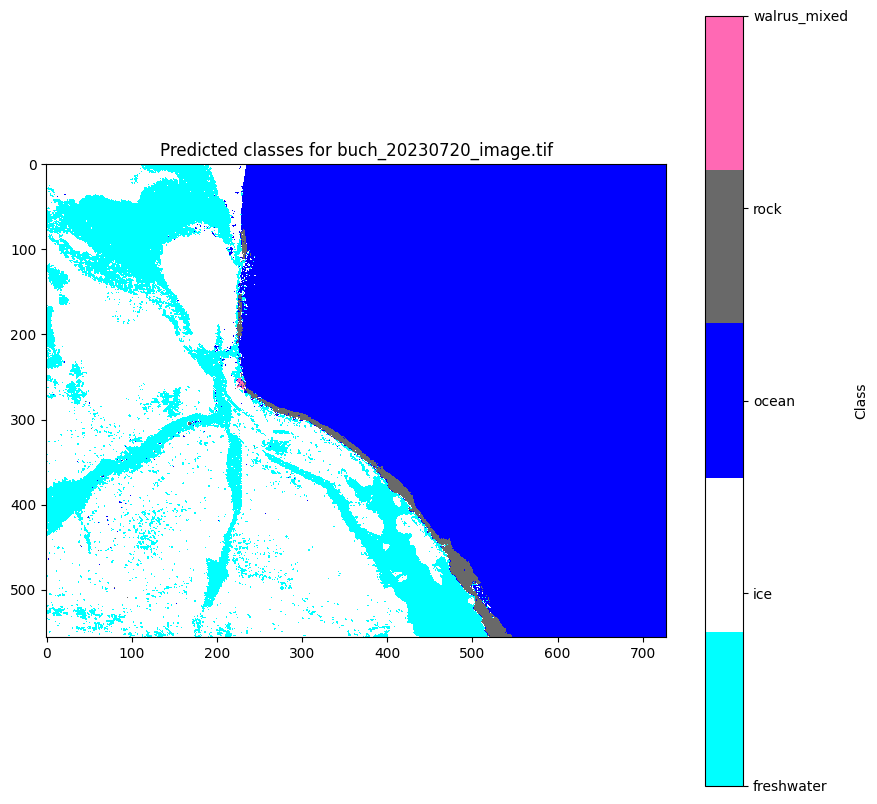

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


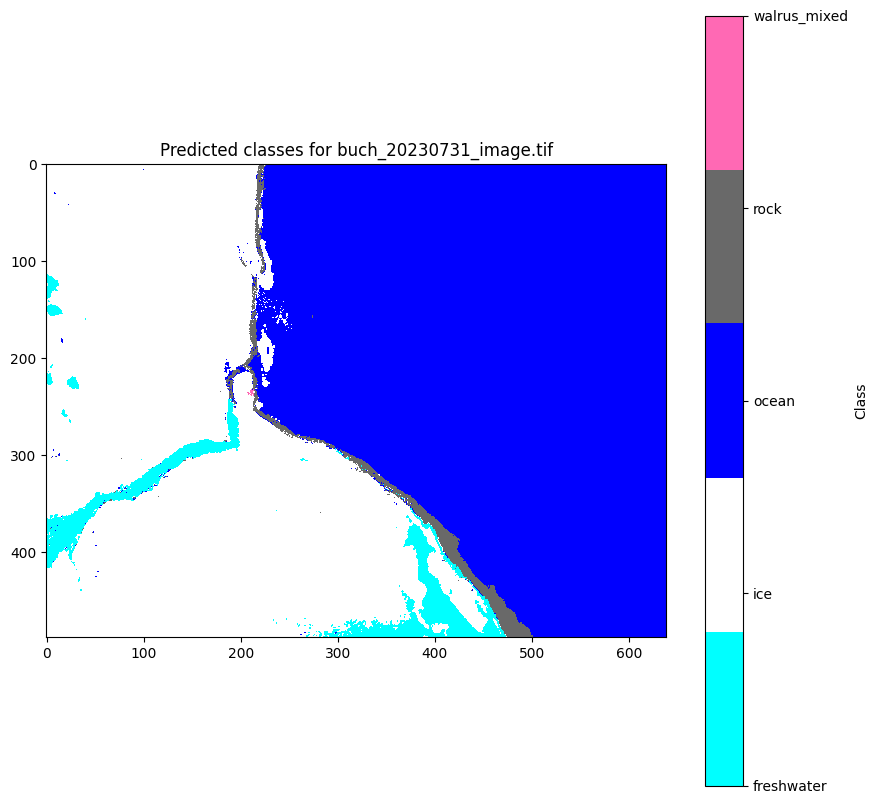

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


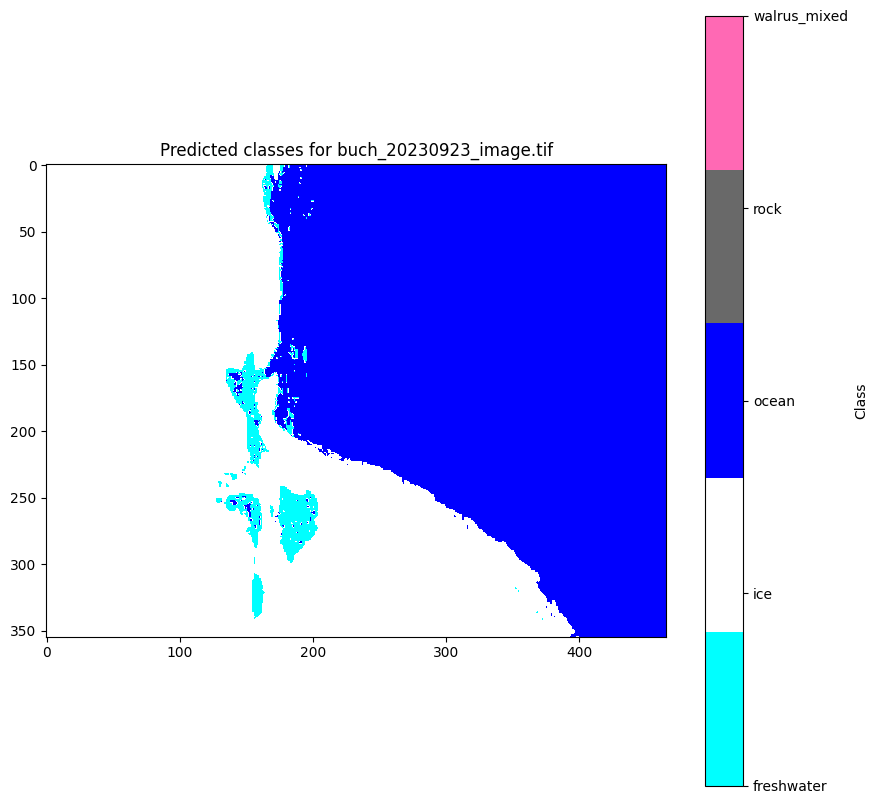

In [15]:
# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [16]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")


Model loaded from walrus_model_buch.joblib


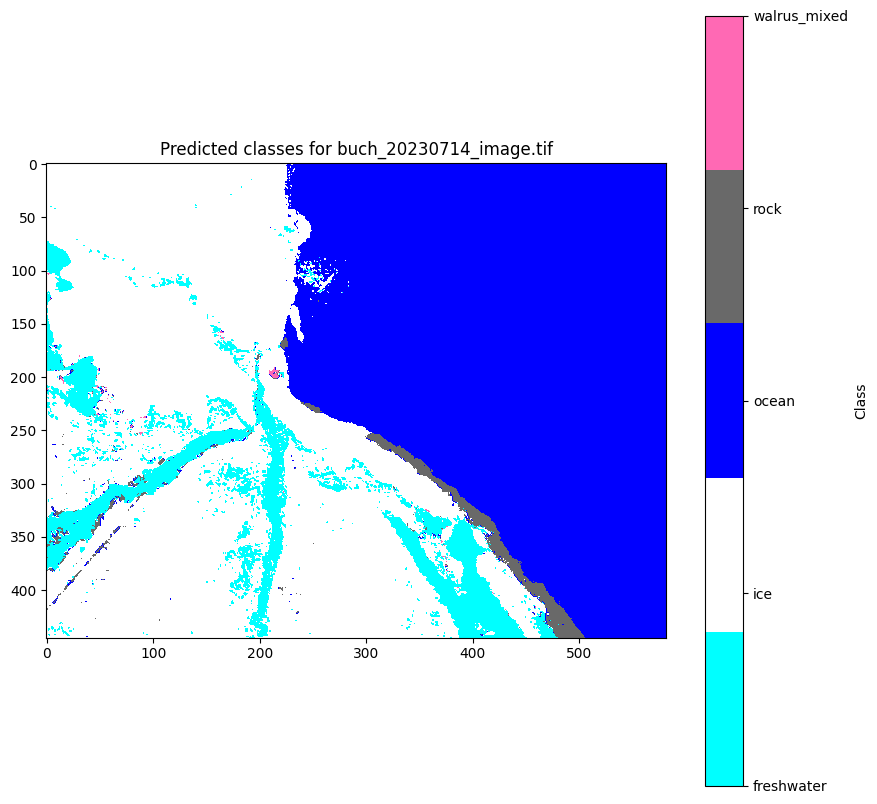

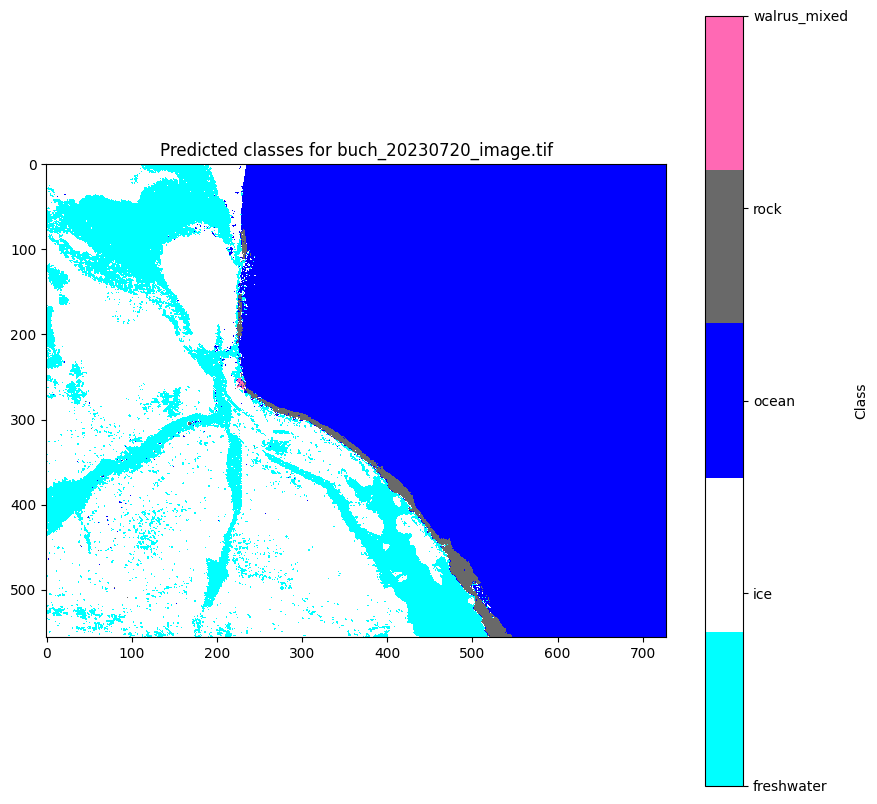

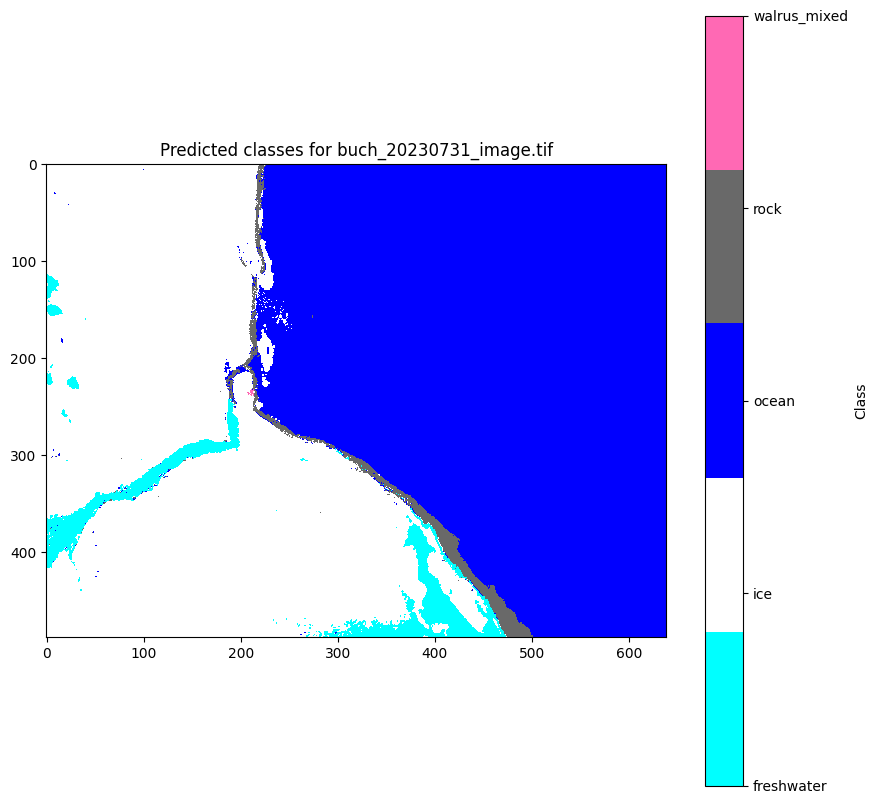

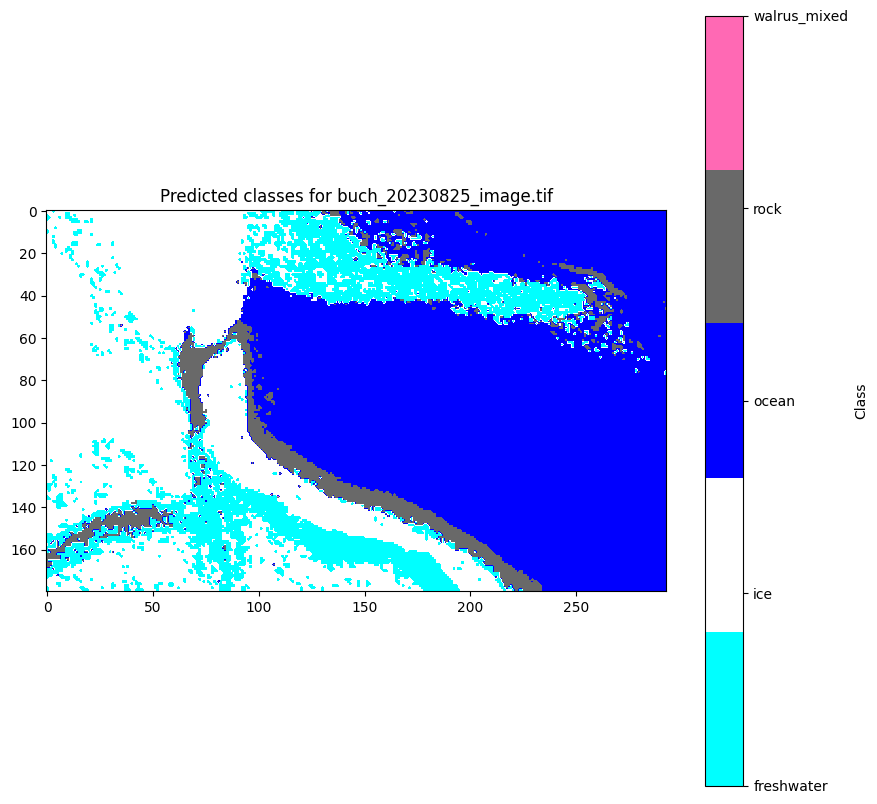

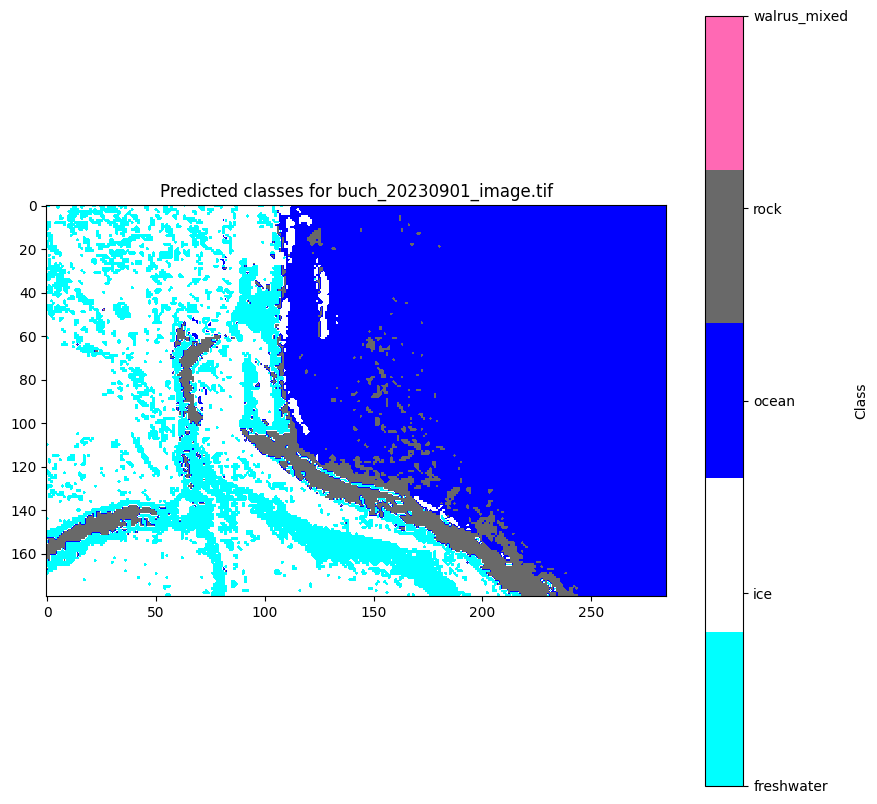

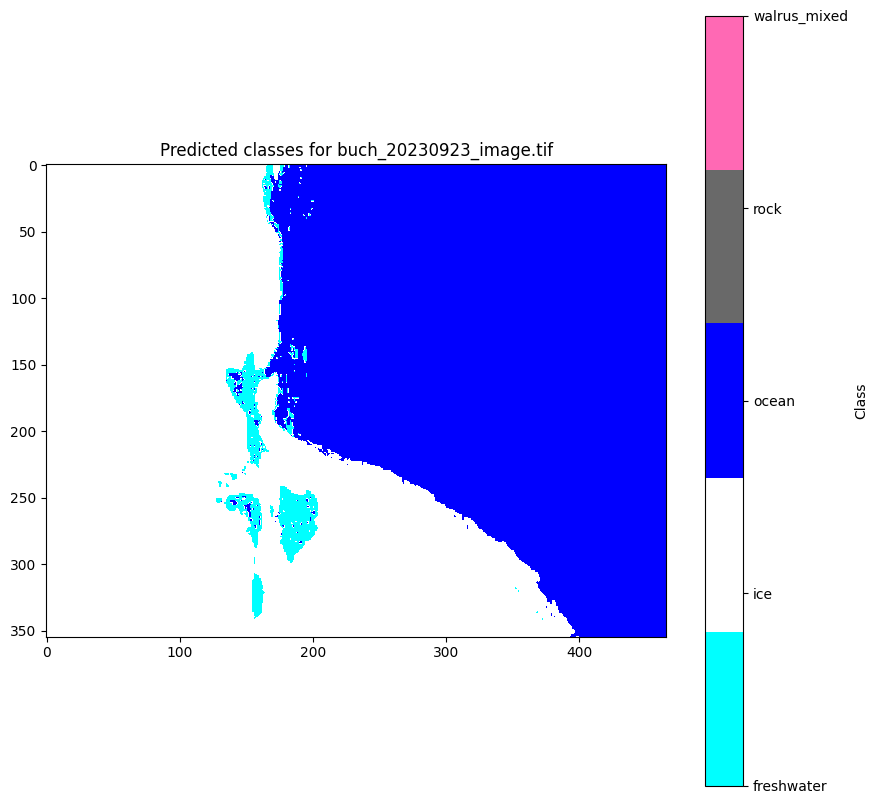

In [17]:
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()


Model loaded from walrus_model_buch.joblib
Ground truth image not found for buch_20230714_image.tif
Ground truth image not found for buch_20230720_image.tif
Ground truth image not found for buch_20230731_image.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


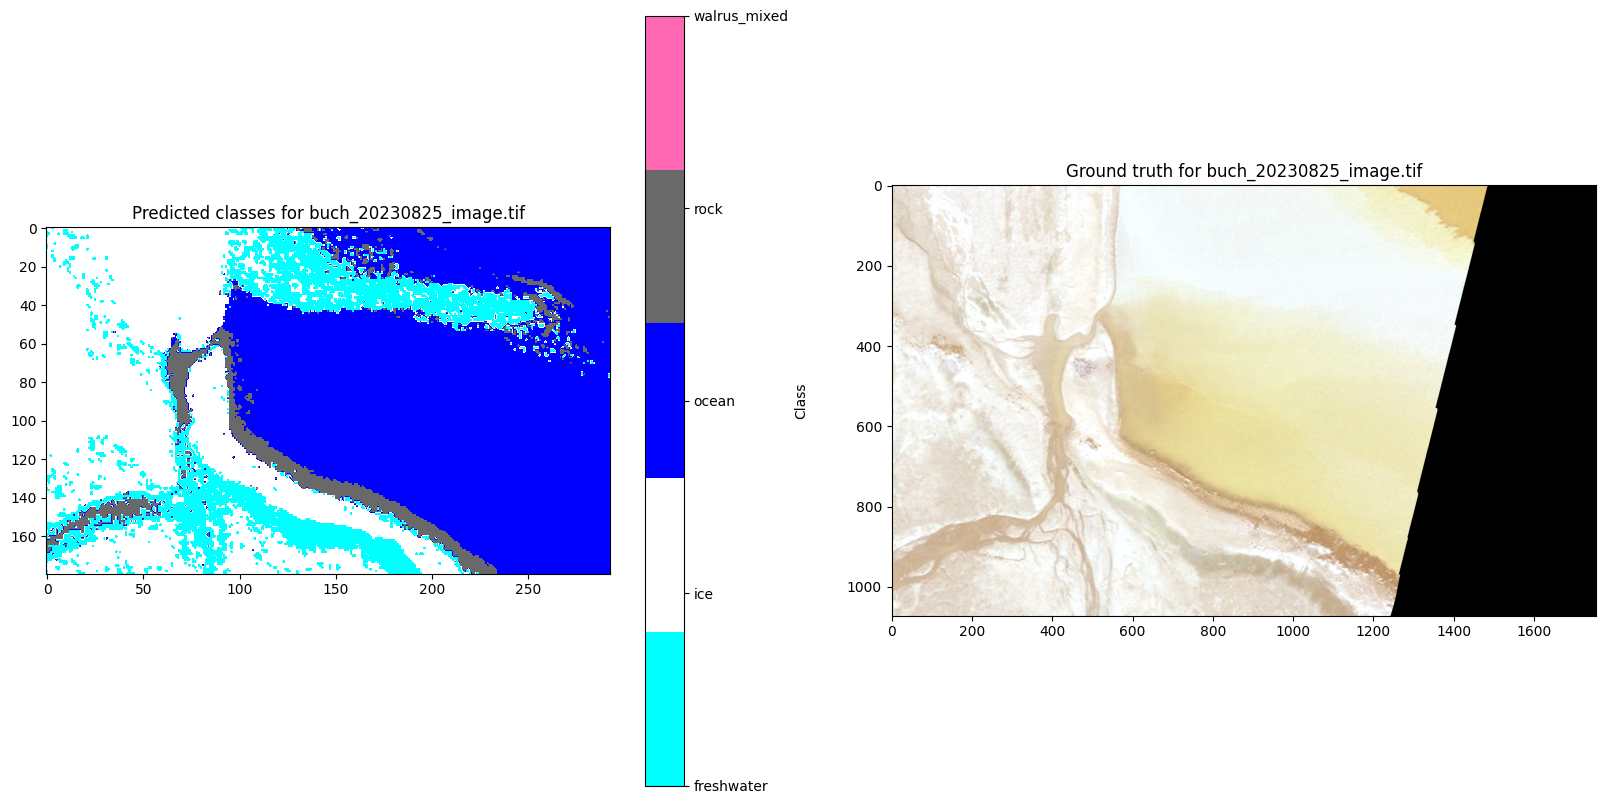

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


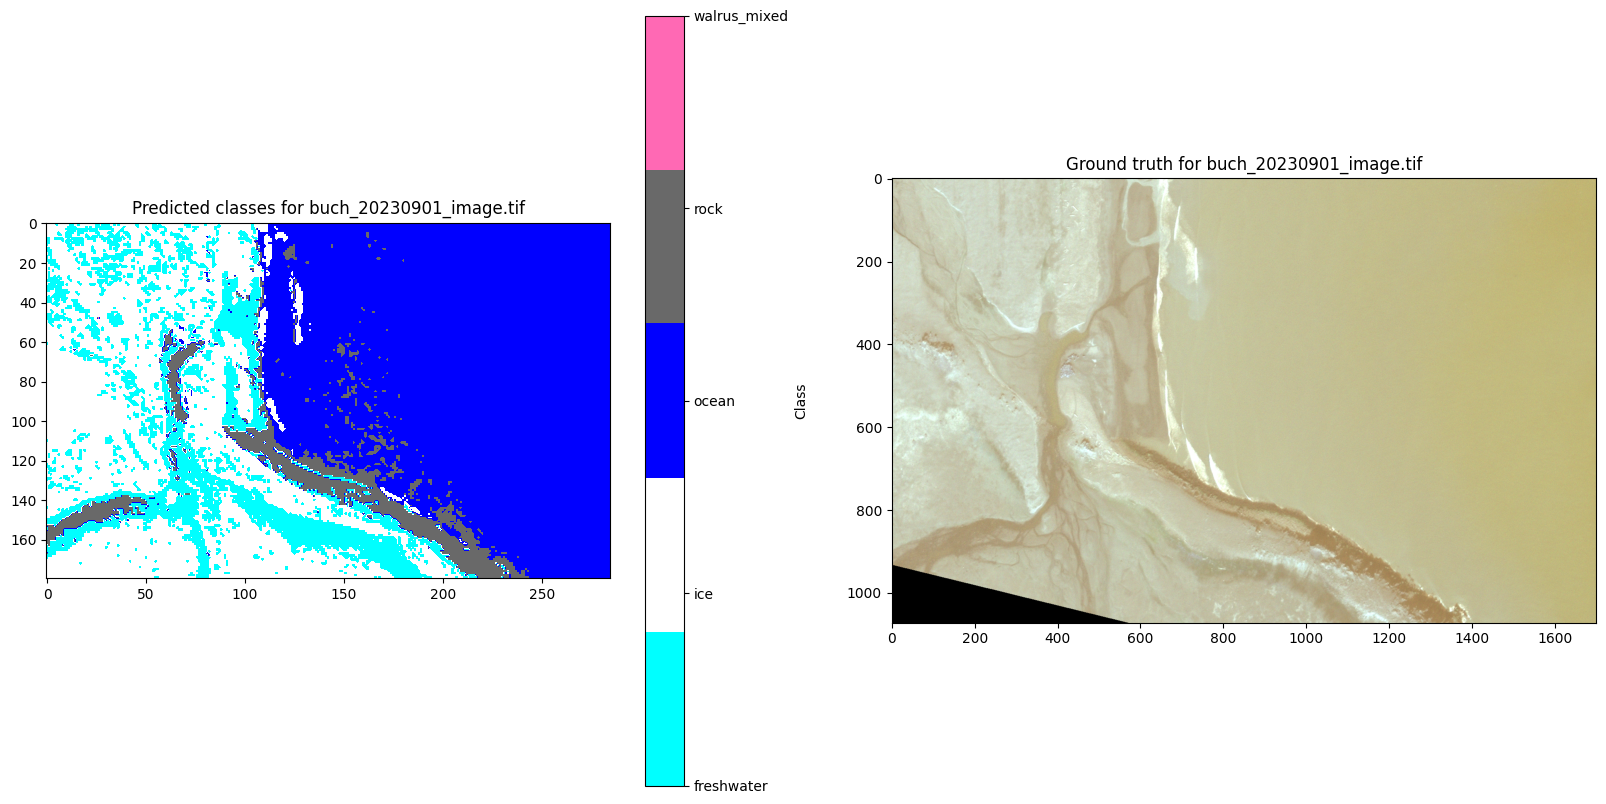

Ground truth image not found for buch_20230923_image.tif


In [22]:
# Path to ground truth images
groundtruth_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\buch_groundtruth"
groundtruth_image_paths = glob.glob(f"{groundtruth_image_dir}/*.tif")

# Function to get ground truth image path
def get_groundtruth_image_path(image_path):
    base_name = os.path.basename(image_path)
    groundtruth_name = base_name.replace('_image', '_groundtruth')
    return os.path.join(groundtruth_image_dir, groundtruth_name)

# Function to load ground truth image
def load_groundtruth_image(image_path):
    with rasterio.open(image_path) as src:
        return src.read()  # Read all bands

# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    groundtruth_image_path = get_groundtruth_image_path(image_path)
    
    if not os.path.exists(groundtruth_image_path):
        print(f"Ground truth image not found for {os.path.basename(image_path)}")
        continue

    groundtruth_image = load_groundtruth_image(groundtruth_image_path)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot predicted image
    axes[0].set_title(f"Predicted classes for {os.path.basename(image_path)}")
    im = axes[0].imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    cbar = plt.colorbar(im, ax=axes[0], ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    # Plot ground truth image
    axes[1].set_title(f"Ground truth for {os.path.basename(image_path)}")
    # Ensure ground truth image is in the correct shape
    groundtruth_image_rgb = groundtruth_image[:3].transpose(1, 2, 0)
    axes[1].imshow(groundtruth_image_rgb)

    plt.show()

PAL

In [23]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\pal_image"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\pal_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\pal_unseen"  

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Path to ground truth images
groundtruth_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\pal_groundtruth"
groundtruth_image_paths = glob.glob(f"{groundtruth_image_dir}/*.tif")

In [24]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

In [25]:
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path


In [26]:
# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\pal_image\pal_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\pal_train\pal_20230714.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\pal_image\pal_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\pal_train\pal_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\pal_image\pal_20230726_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\pal_train\pal_20230726_train.shp


In [27]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [28]:
# Save the model
model_filename = "walrus_model_pal.joblib"
joblib.dump(model, model_filename)


['walrus_model_pal.joblib']

In [29]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

         ice       0.99      0.97      0.98      1920
       ocean       1.00      1.00      1.00     15577
        rock       0.99      1.00      1.00     16551
walrus_mixed       1.00      0.30      0.46        47

    accuracy                           1.00     34095
   macro avg       1.00      0.82      0.86     34095
weighted avg       1.00      1.00      1.00     34095


In [30]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


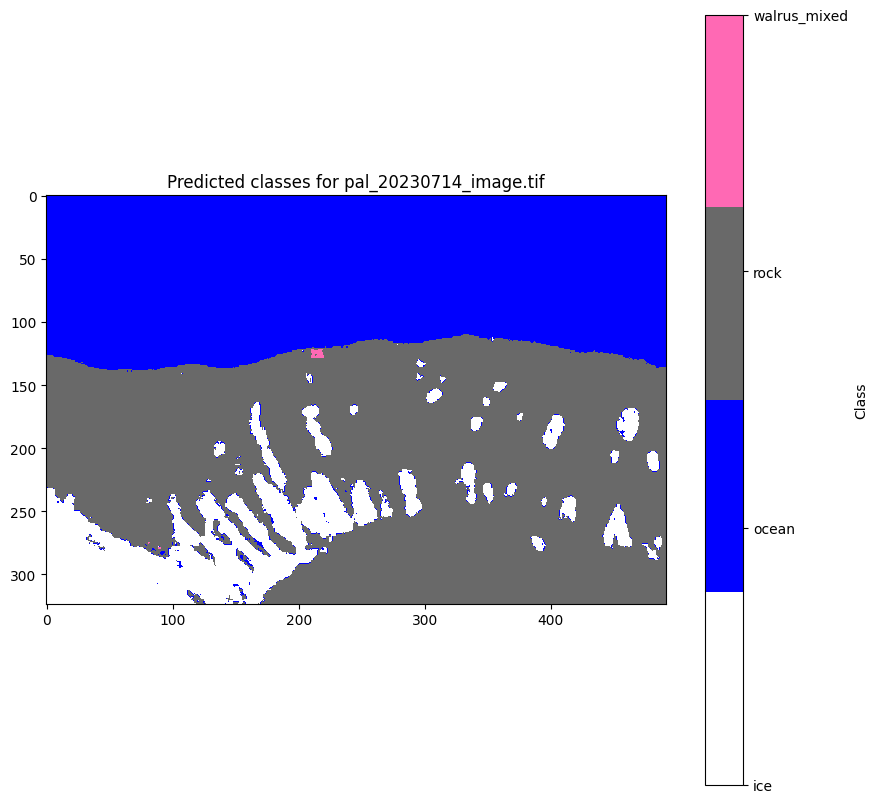

Labels present in pal_20230720_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


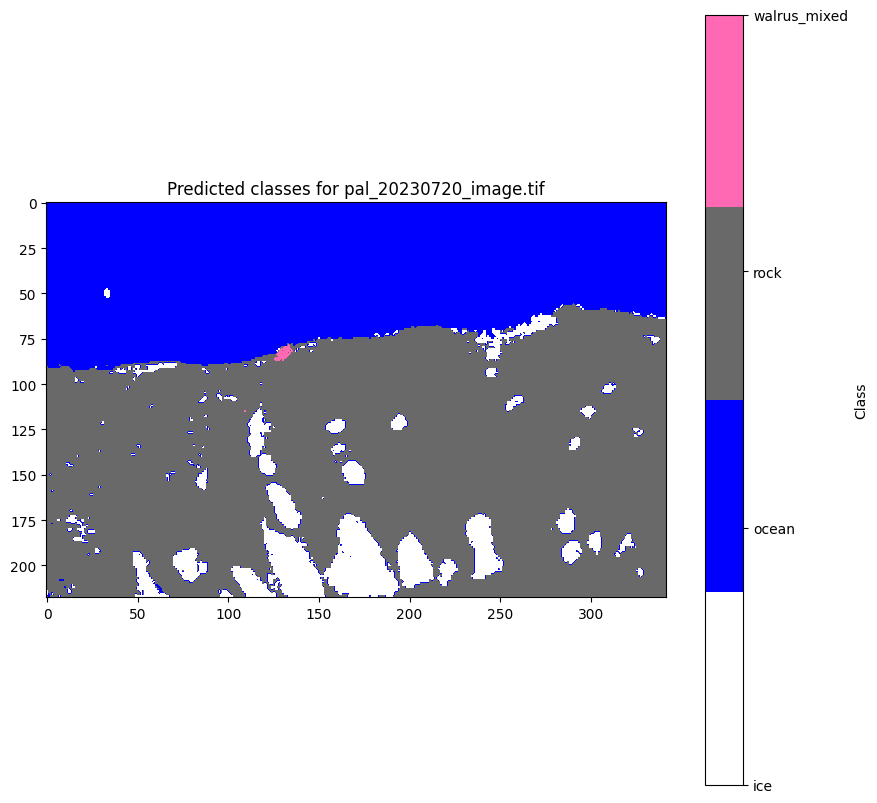

Labels present in pal_20230726_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


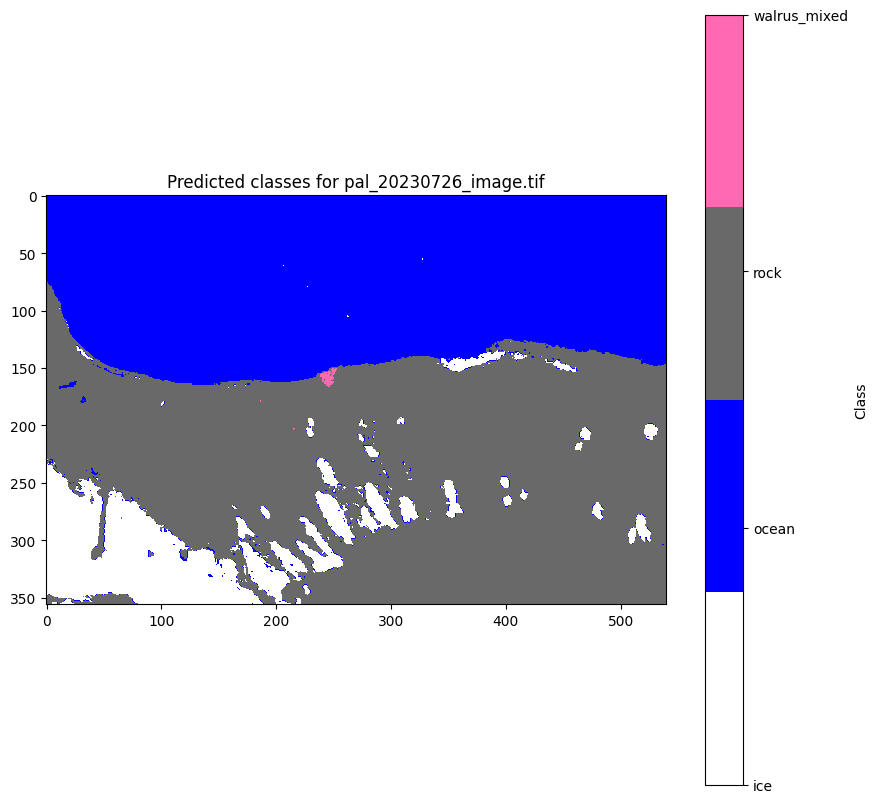

In [31]:
# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [32]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")


Model loaded from walrus_model_pal.joblib


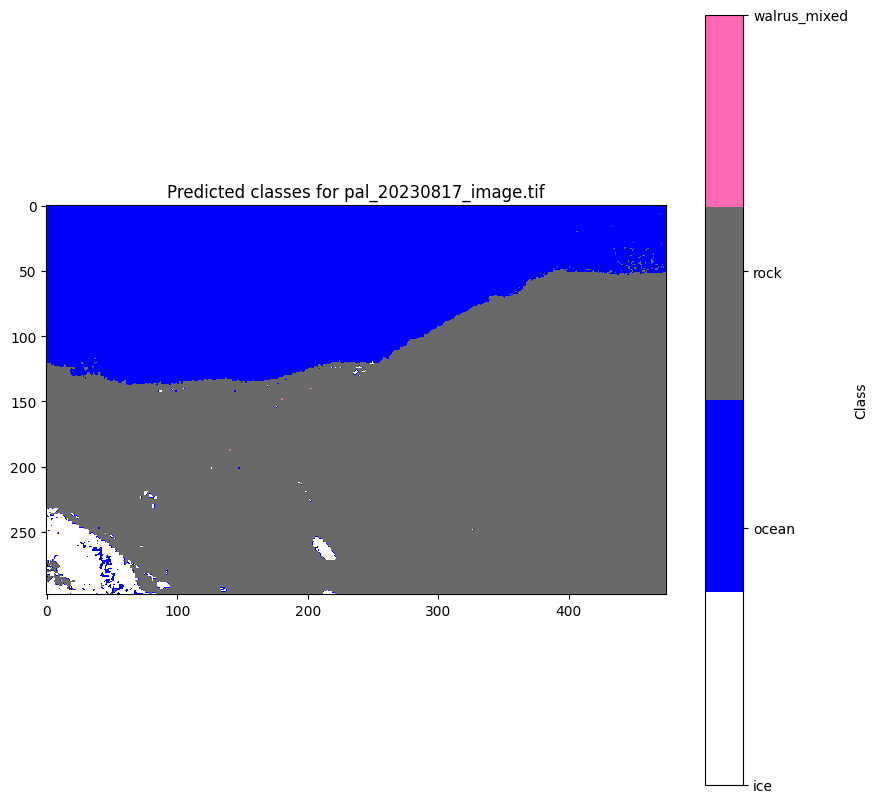

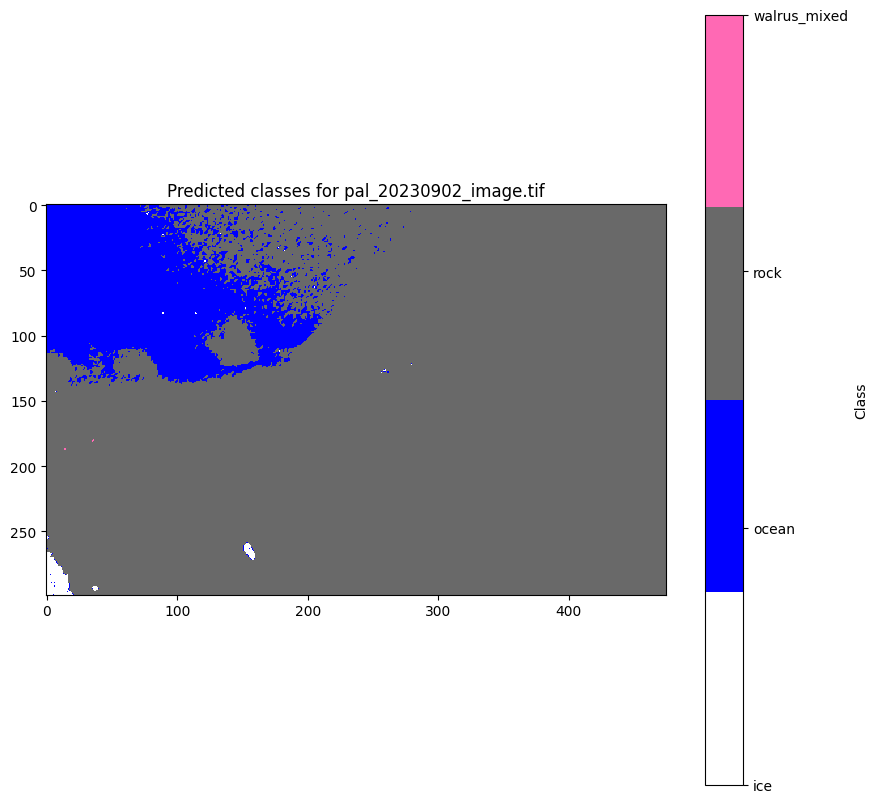

In [33]:
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()


Model loaded from walrus_model_pal.joblib


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


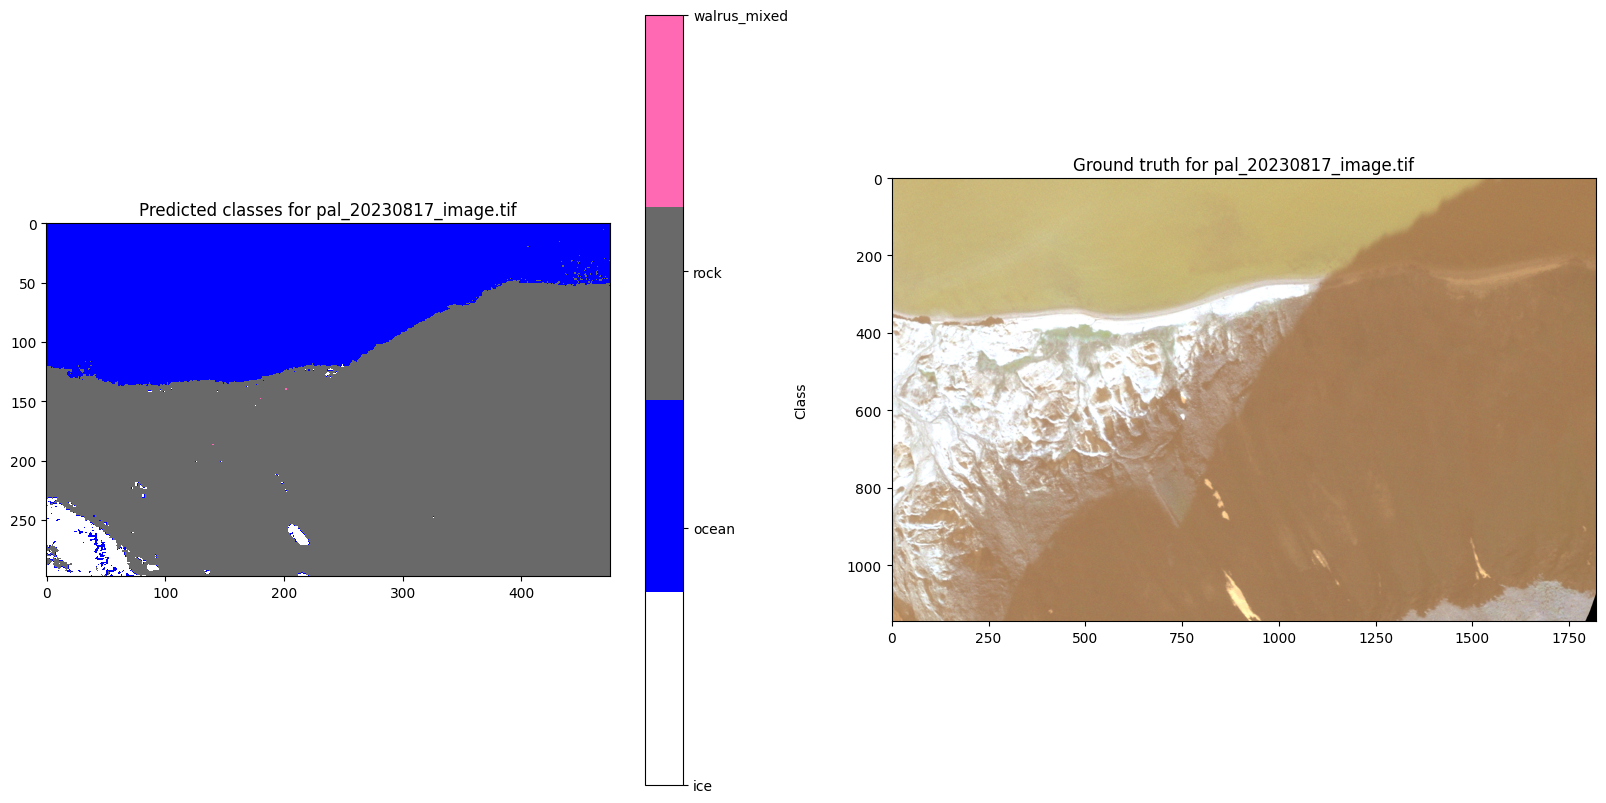

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


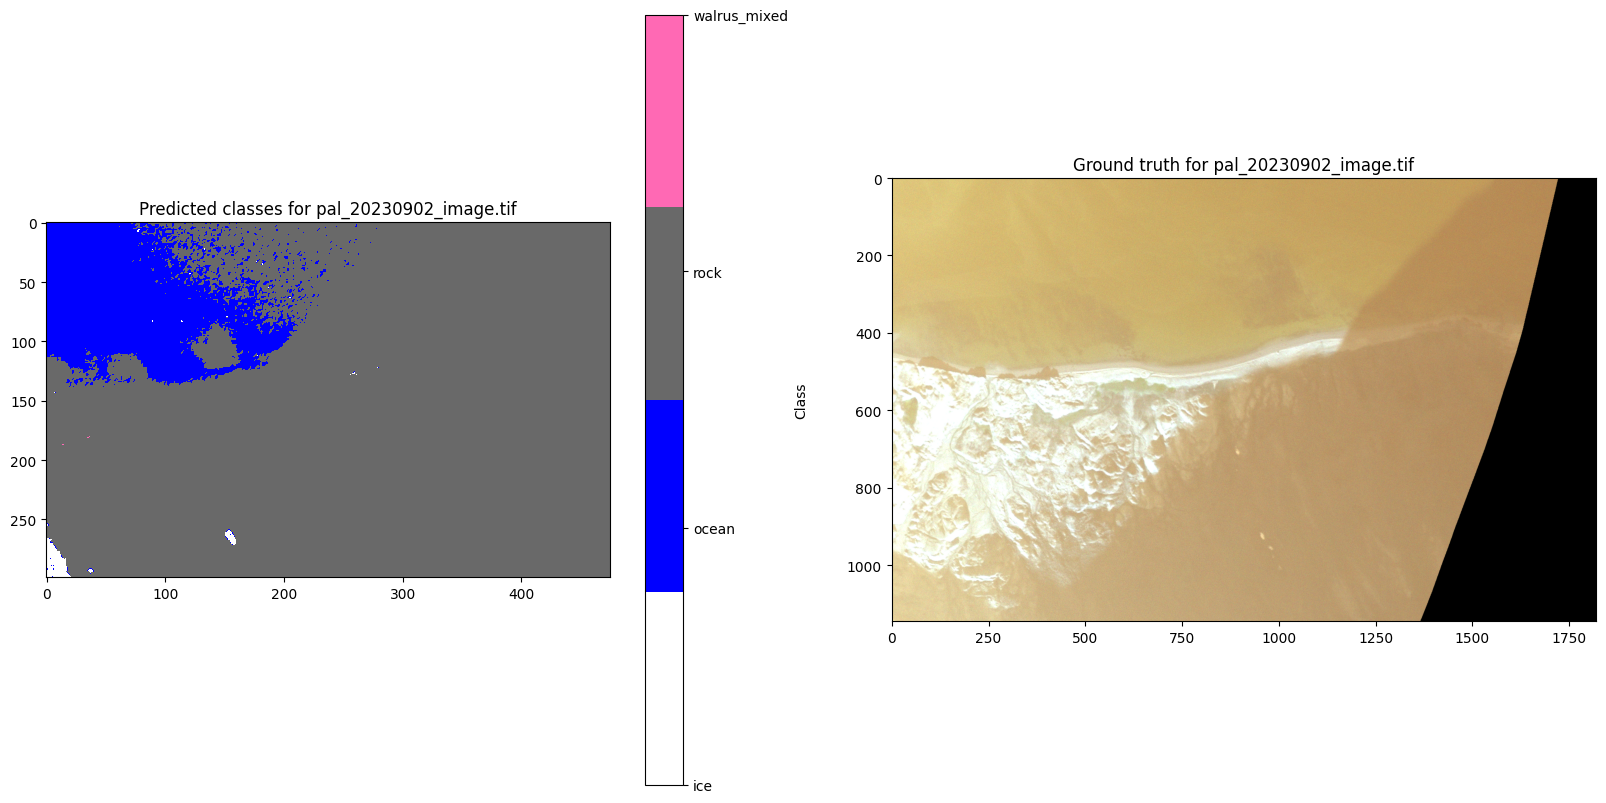

In [34]:
# Function to get ground truth image path
def get_groundtruth_image_path(image_path):
    base_name = os.path.basename(image_path)
    groundtruth_name = base_name.replace('_image', '_groundtruth')
    return os.path.join(groundtruth_image_dir, groundtruth_name)

# Function to load ground truth image
def load_groundtruth_image(image_path):
    with rasterio.open(image_path) as src:
        return src.read()  # Read all bands

# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    groundtruth_image_path = get_groundtruth_image_path(image_path)
    
    if not os.path.exists(groundtruth_image_path):
        print(f"Ground truth image not found for {os.path.basename(image_path)}")
        continue

    groundtruth_image = load_groundtruth_image(groundtruth_image_path)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot predicted image
    axes[0].set_title(f"Predicted classes for {os.path.basename(image_path)}")
    im = axes[0].imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    cbar = plt.colorbar(im, ax=axes[0], ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    # Plot ground truth image
    axes[1].set_title(f"Ground truth for {os.path.basename(image_path)}")
    # Ensure ground truth image is in the correct shape
    groundtruth_image_rgb = groundtruth_image[:3].transpose(1, 2, 0)
    axes[1].imshow(groundtruth_image_rgb)

    plt.show()

SARS

In [35]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\sars_image"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\sars_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\sars_unseen"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Path to ground truth images
groundtruth_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\sars_groundtruth"
groundtruth_image_paths = glob.glob(f"{groundtruth_image_dir}/*.tif")

In [36]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None


# Create a dictionary to store paired image and shapefile paths
file_pairs = {}
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")


def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)

    return np.array(features), np.array(labels)


features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)


Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\sars_image\sars_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\sars_train\sars_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\sars_image\sars_20230803_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\sars_train\sars_20230803_train.shp


In [37]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
# Save the model
model_filename = "walrus_model_sars.joblib"
joblib.dump(model, model_filename)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

         ice       0.99      0.99      0.99      1188
       ocean       1.00      1.00      1.00     28619
walrus_mixed       1.00      0.58      0.74        24

    accuracy                           1.00     29831
   macro avg       1.00      0.86      0.91     29831
weighted avg       1.00      1.00      1.00     29831


In [39]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))


predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink',
                'freshwater': 'cyan', 'ocean': 'blue'}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

Labels present in sars_20230714_image.tif: ['ice', 'ocean', 'walrus_mixed']


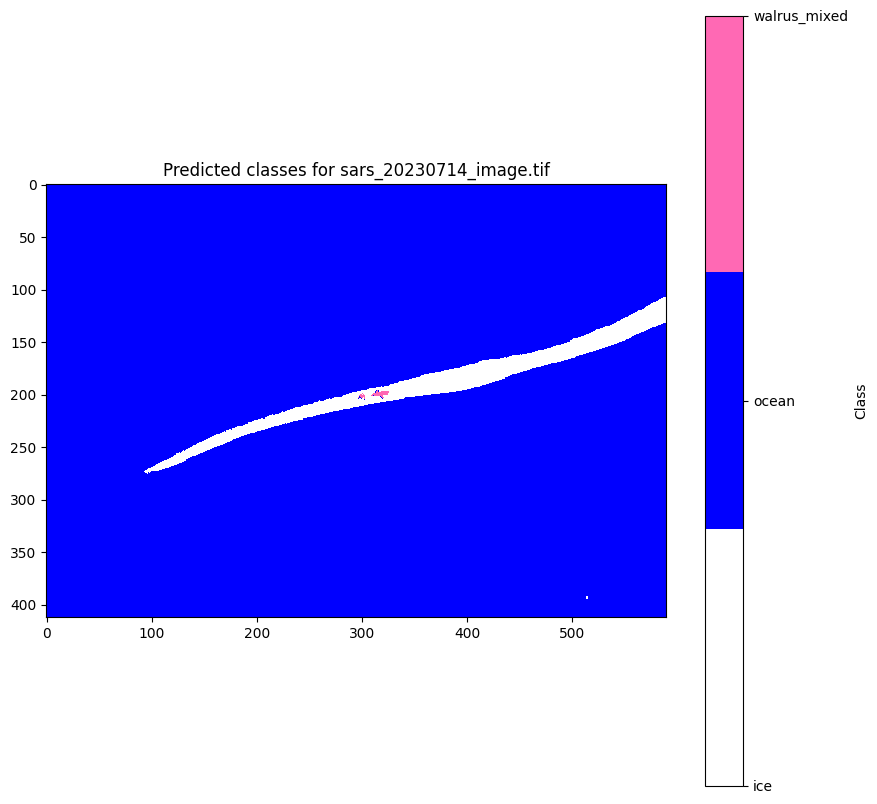

Labels present in sars_20230803_image.tif: ['ice', 'ocean', 'walrus_mixed']


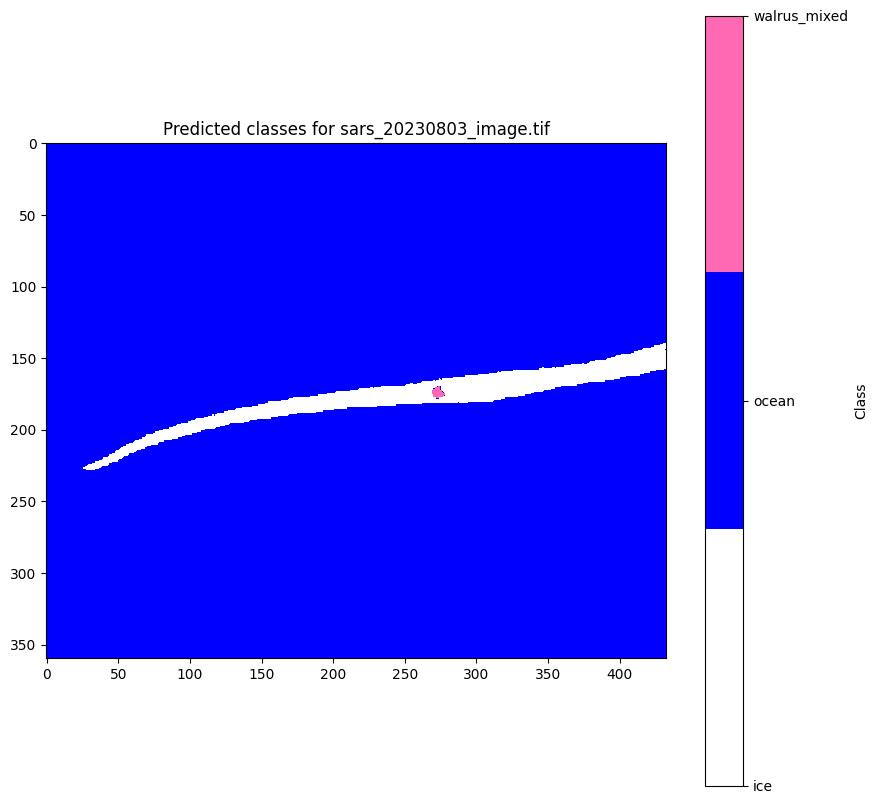

In [40]:
# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_) - 1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

Model loaded from walrus_model_sars.joblib


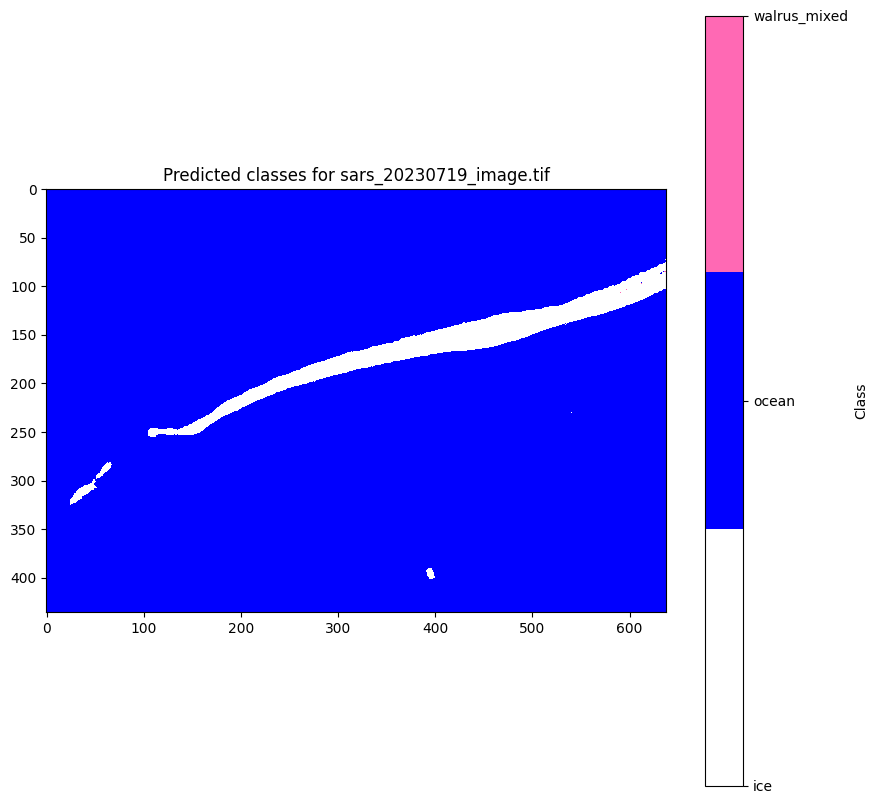

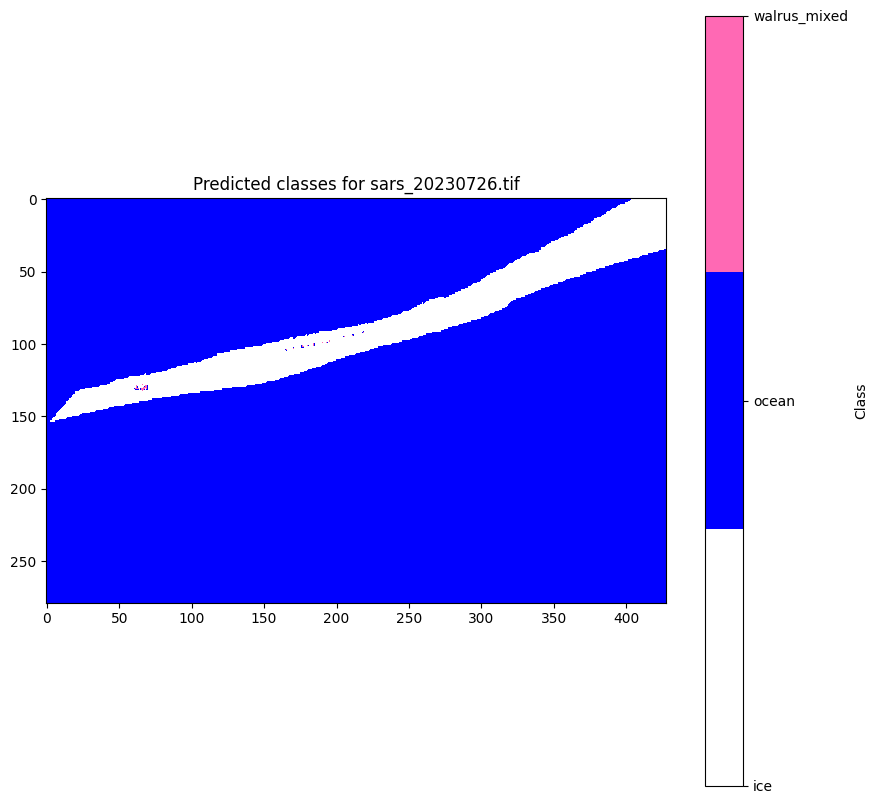

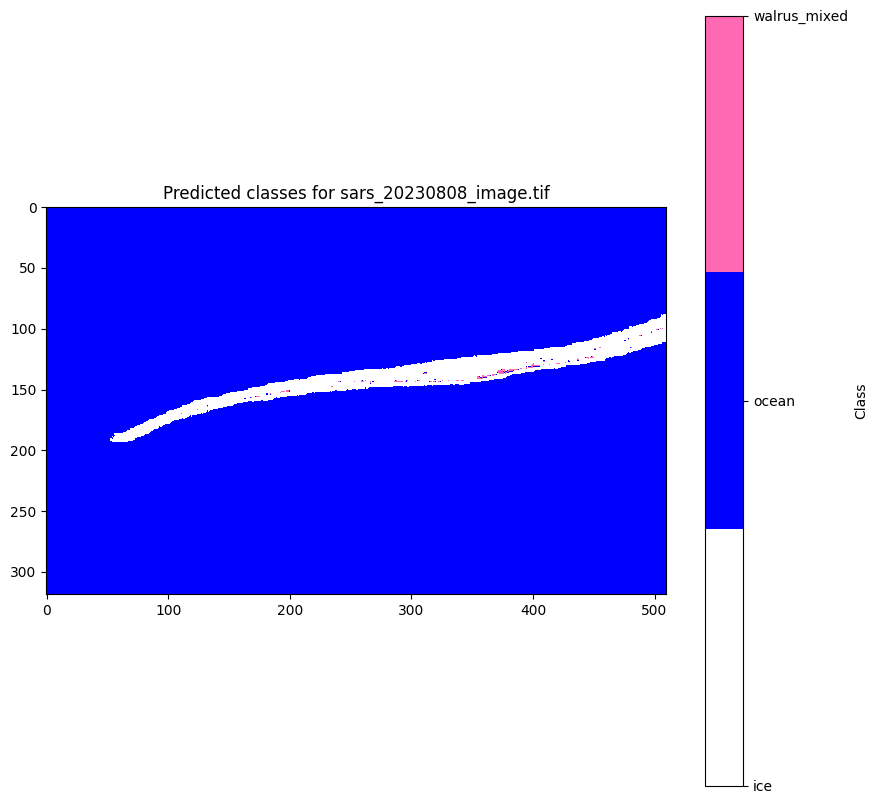

In [41]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)

    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_) - 1)

    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)

    plt.show()


In [42]:
# Function to get ground truth image path
def get_groundtruth_image_path(image_path):
    base_name = os.path.basename(image_path)
    groundtruth_name = base_name.replace('_image', '_groundtruth')
    return os.path.join(groundtruth_image_dir, groundtruth_name)


# Function to load ground truth image
def load_groundtruth_image(image_path):
    with rasterio.open(image_path) as src:
        return src.read()  # Read all bands


# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from walrus_model_sars.joblib


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


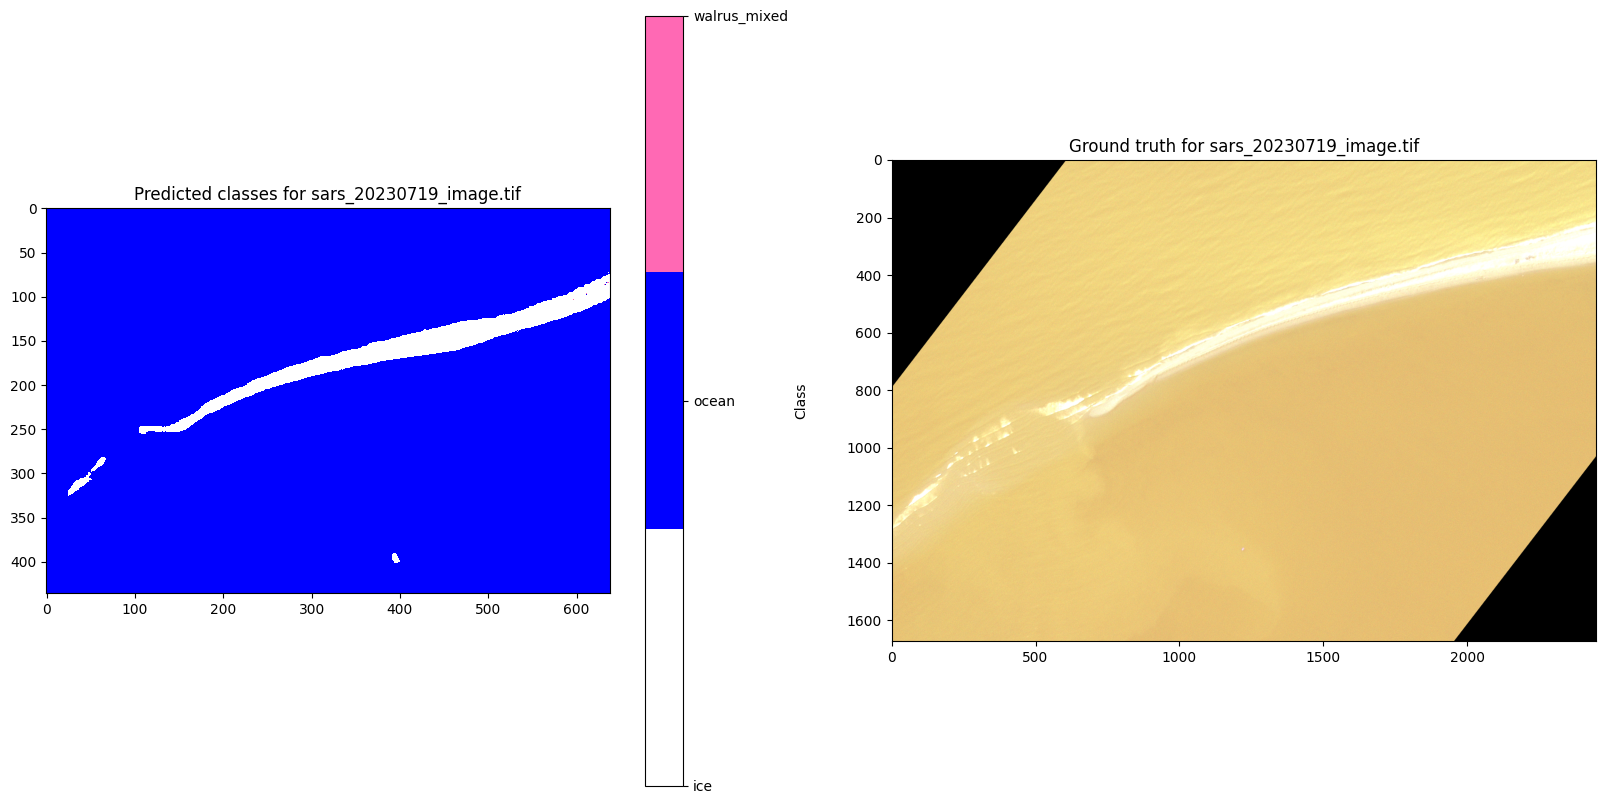

Ground truth image not found for sars_20230726.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


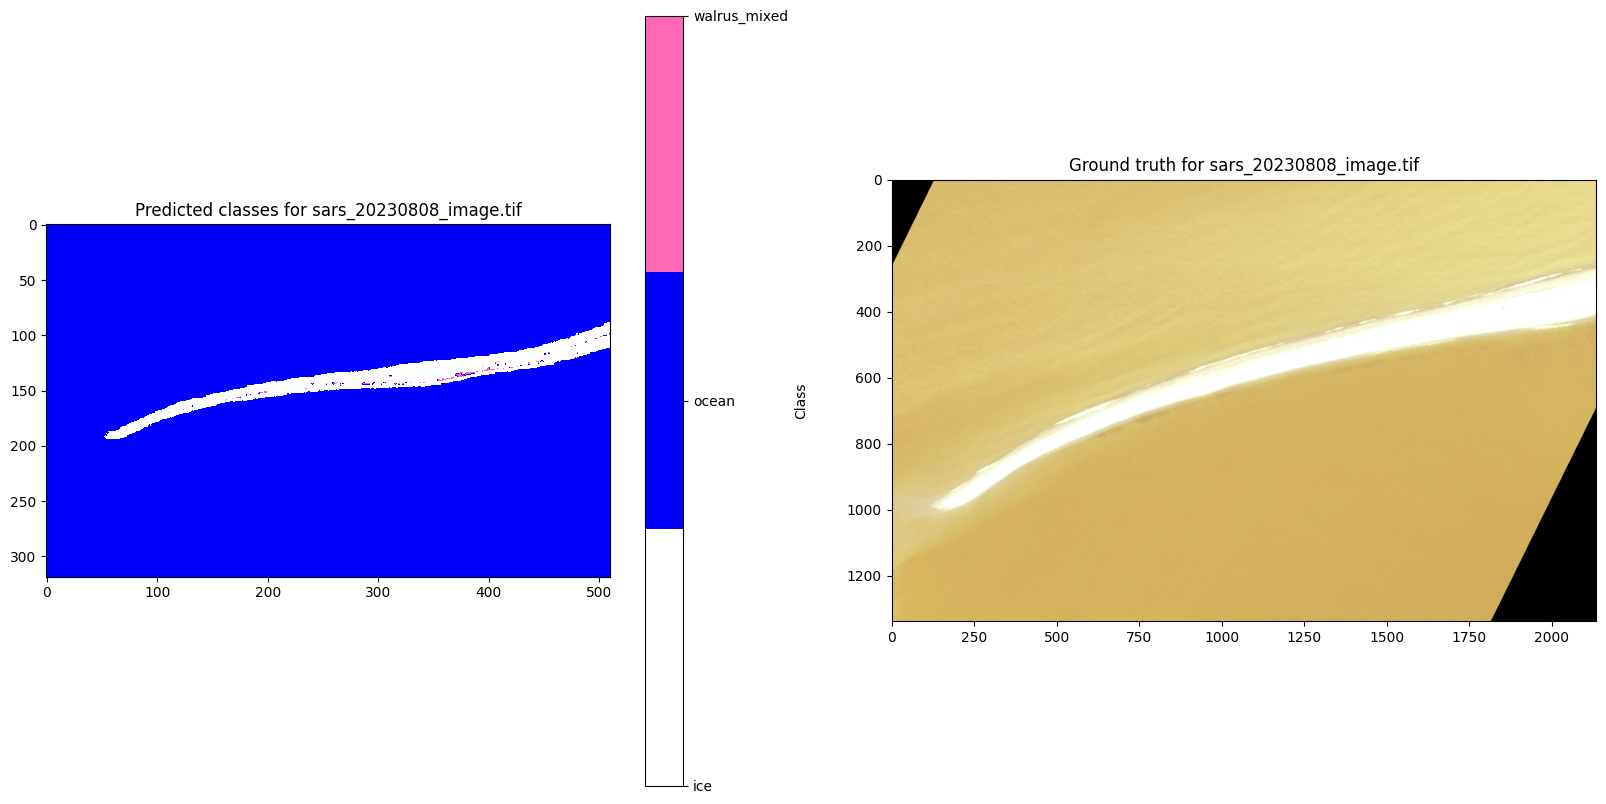

In [43]:


for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    groundtruth_image_path = get_groundtruth_image_path(image_path)

    if not os.path.exists(groundtruth_image_path):
        print(f"Ground truth image not found for {os.path.basename(image_path)}")
        continue

    groundtruth_image = load_groundtruth_image(groundtruth_image_path)

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Plot predicted image
    axes[0].set_title(f"Predicted classes for {os.path.basename(image_path)}")
    im = axes[0].imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_) - 1)
    cbar = plt.colorbar(im, ax=axes[0], ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)

    # Plot ground truth image
    axes[1].set_title(f"Ground truth for {os.path.basename(image_path)}")
    # Ensure ground truth image is in the correct shape
    groundtruth_image_rgb = groundtruth_image[:3].transpose(1, 2, 0)
    axes[1].imshow(groundtruth_image_rgb)

    plt.show()

TOR

In [44]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\tor_image"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\tor_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\tor_unseen"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Path to ground truth images
groundtruth_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\tor_groundtruth"
groundtruth_image_paths = glob.glob(f"{groundtruth_image_dir}/*.tif")

In [ ]:
combine the ocean + freshwater = water 

In [45]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None


# Create a dictionary to store paired image and shapefile paths
file_pairs = {}
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")


def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)

    return np.array(features), np.array(labels)


features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)


Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_image\tor_20230801_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_train\tor_20230801_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_image\tor_20230824_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_train\tor_20230824_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_image\tor_20230901_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_train\tor_20230901_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_image\tor_20230902_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_train\tor_20230902_train.shp


In [46]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [47]:
# Save the model
model_filename = "walrus_model_tor.joblib"
joblib.dump(model, model_filename)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  freshwater       0.97      0.94      0.96      1069
         ice       0.99      1.00      0.99     15275
       ocean       1.00      1.00      1.00     37900
        rock       0.80      0.34      0.48       230
walrus_mixed       1.00      0.70      0.82        47
 walrus_pure       0.77      0.91      0.83        11

    accuracy                           0.99     54532
   macro avg       0.92      0.82      0.85     54532
weighted avg       0.99      0.99      0.99     54532


Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


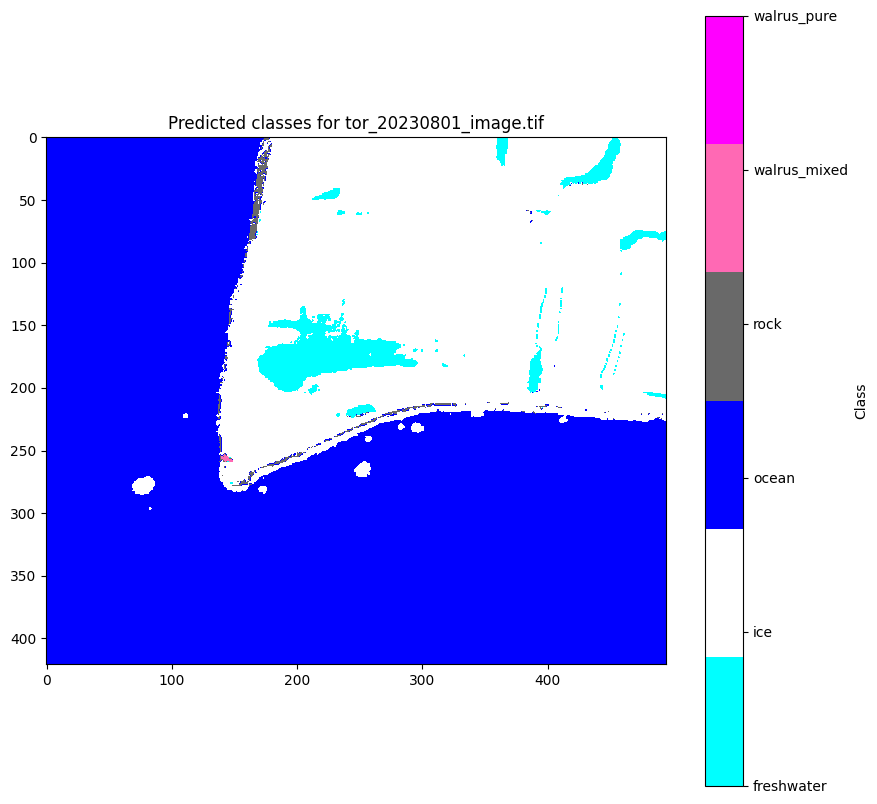

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


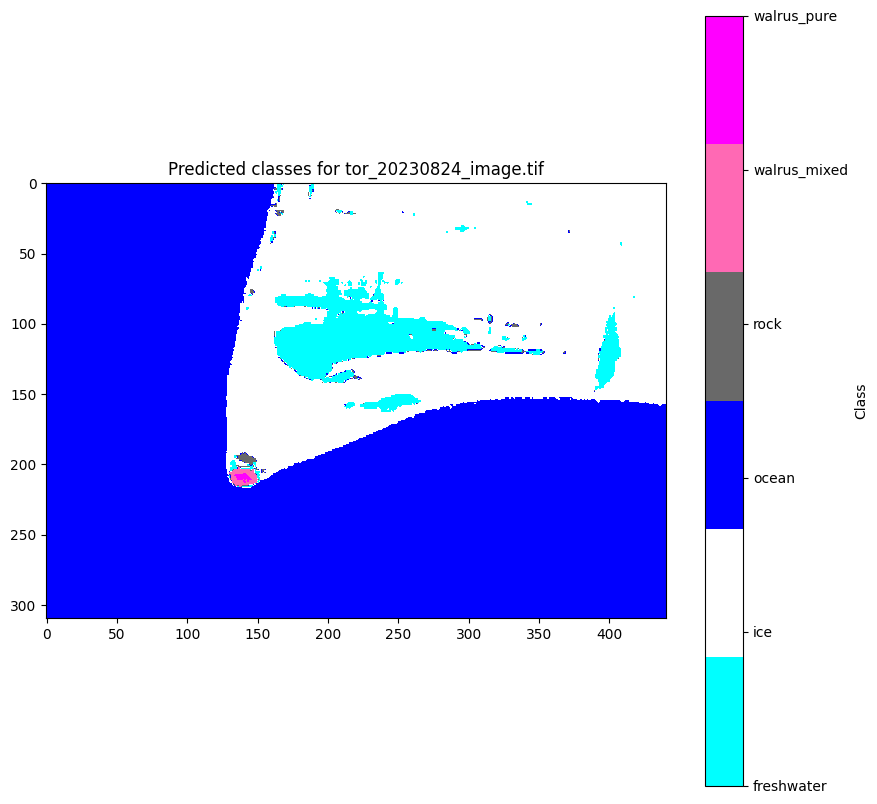

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


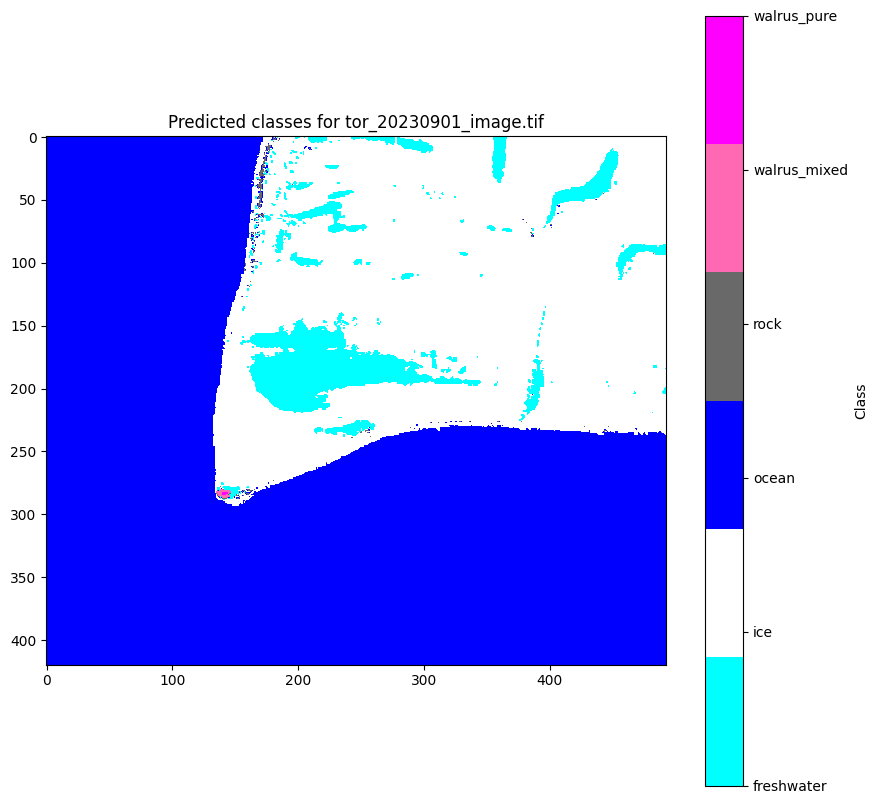

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


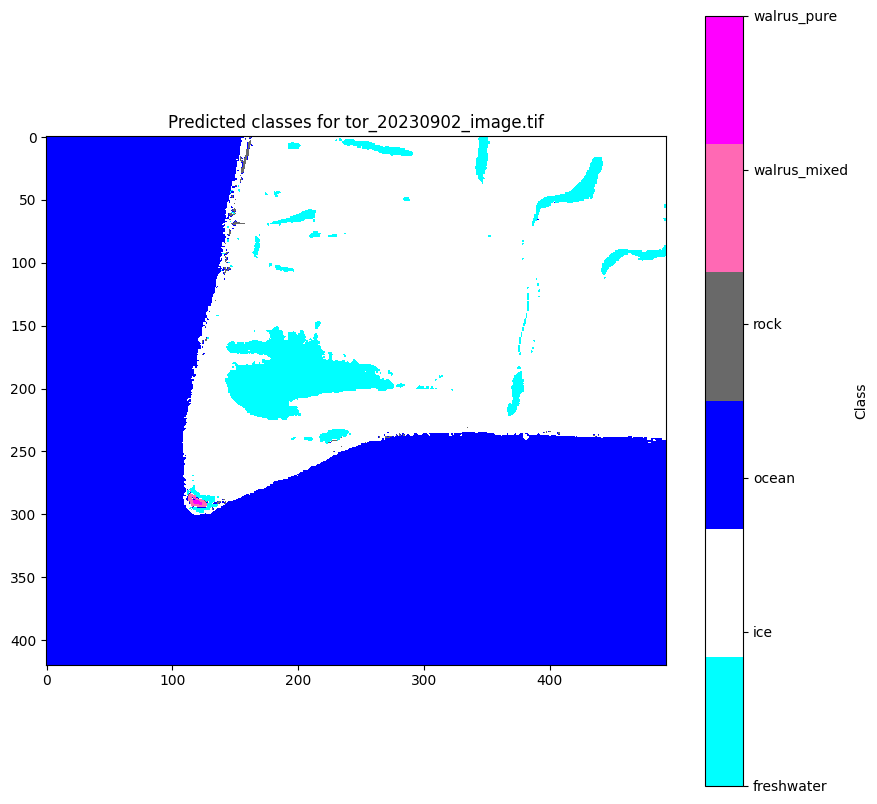

In [48]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))


predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink',
                'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_) - 1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

Model loaded from walrus_model_tor.joblib


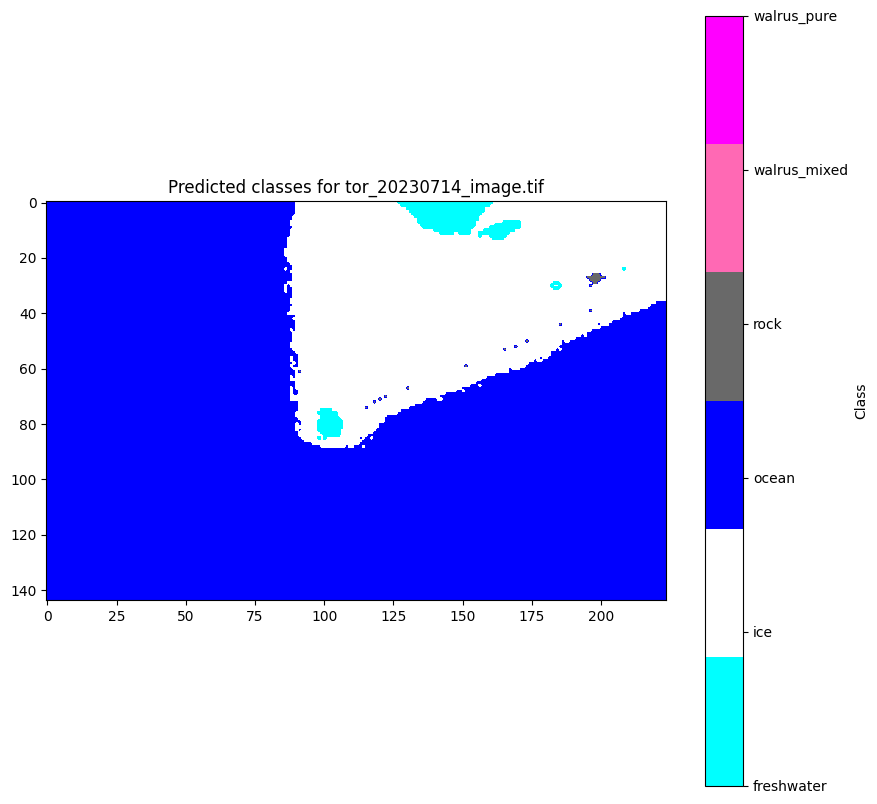

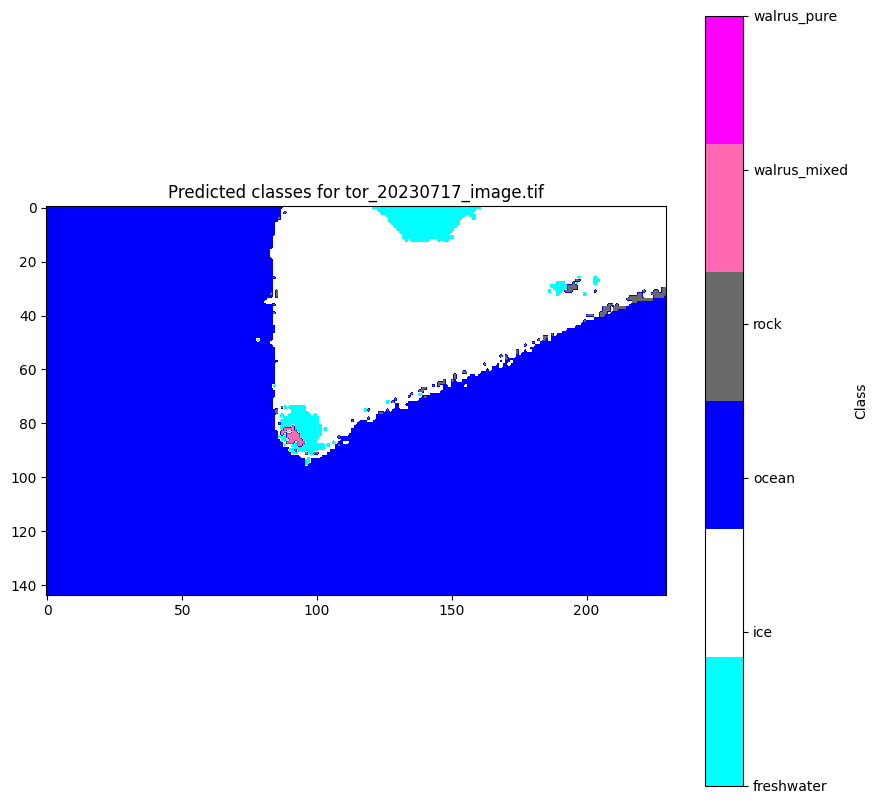

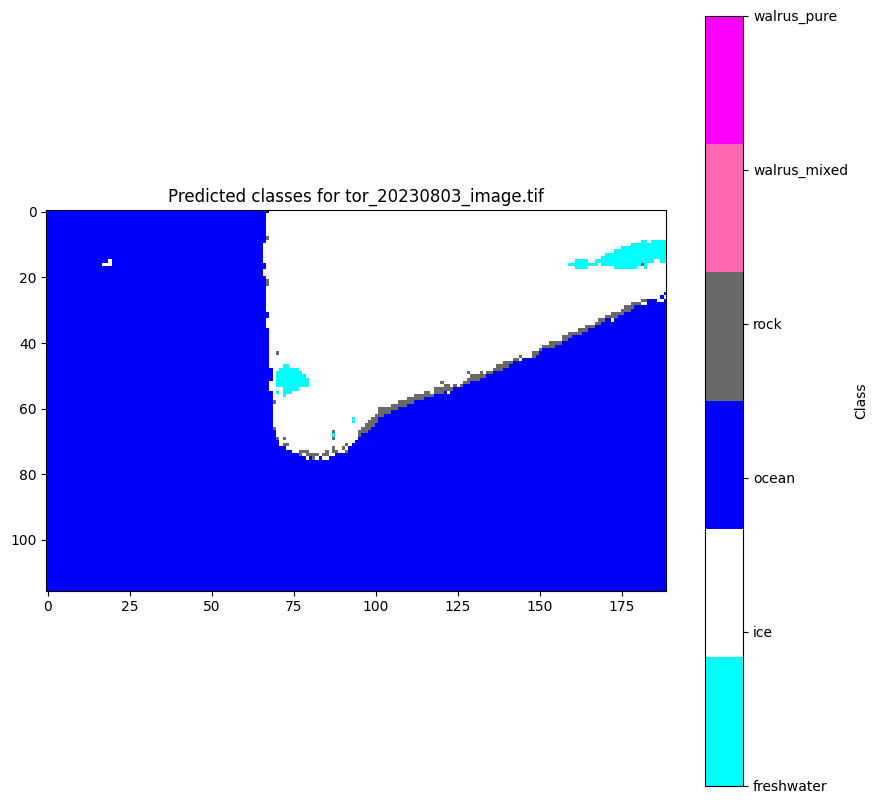

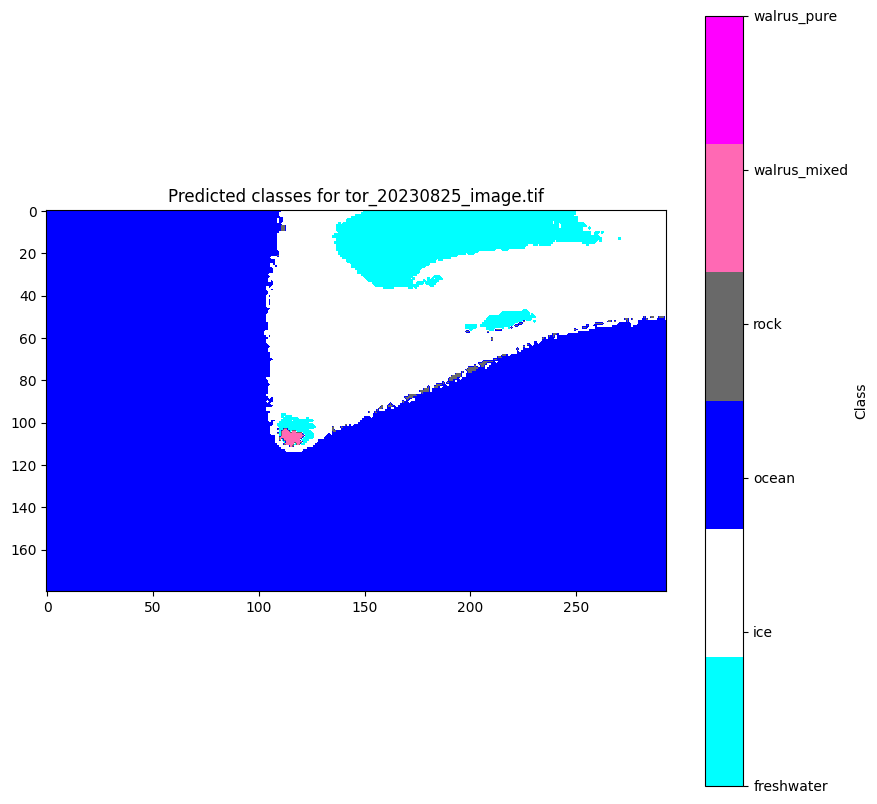

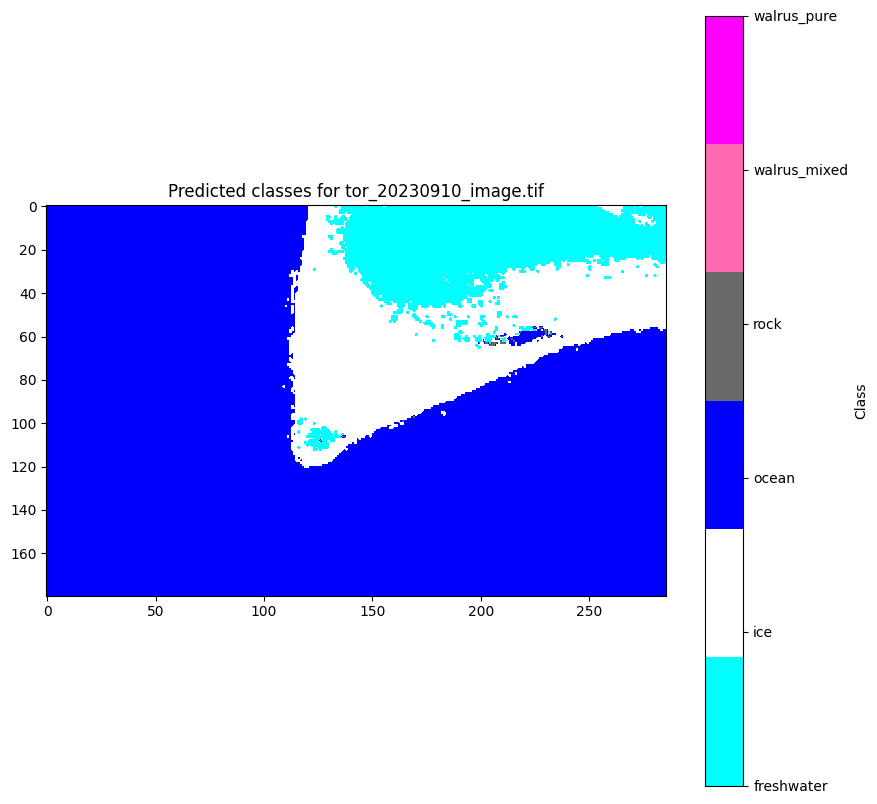

In [49]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)

    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_) - 1)

    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)

    plt.show()

In [50]:
# Function to get ground truth image path
def get_groundtruth_image_path(image_path):
    base_name = os.path.basename(image_path)
    groundtruth_name = base_name.replace('_image', '_groundtruth')
    return os.path.join(groundtruth_image_dir, groundtruth_name)


# Function to load ground truth image
def load_groundtruth_image(image_path):
    with rasterio.open(image_path) as src:
        return src.read()  # Read all bands


# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from walrus_model_tor.joblib


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


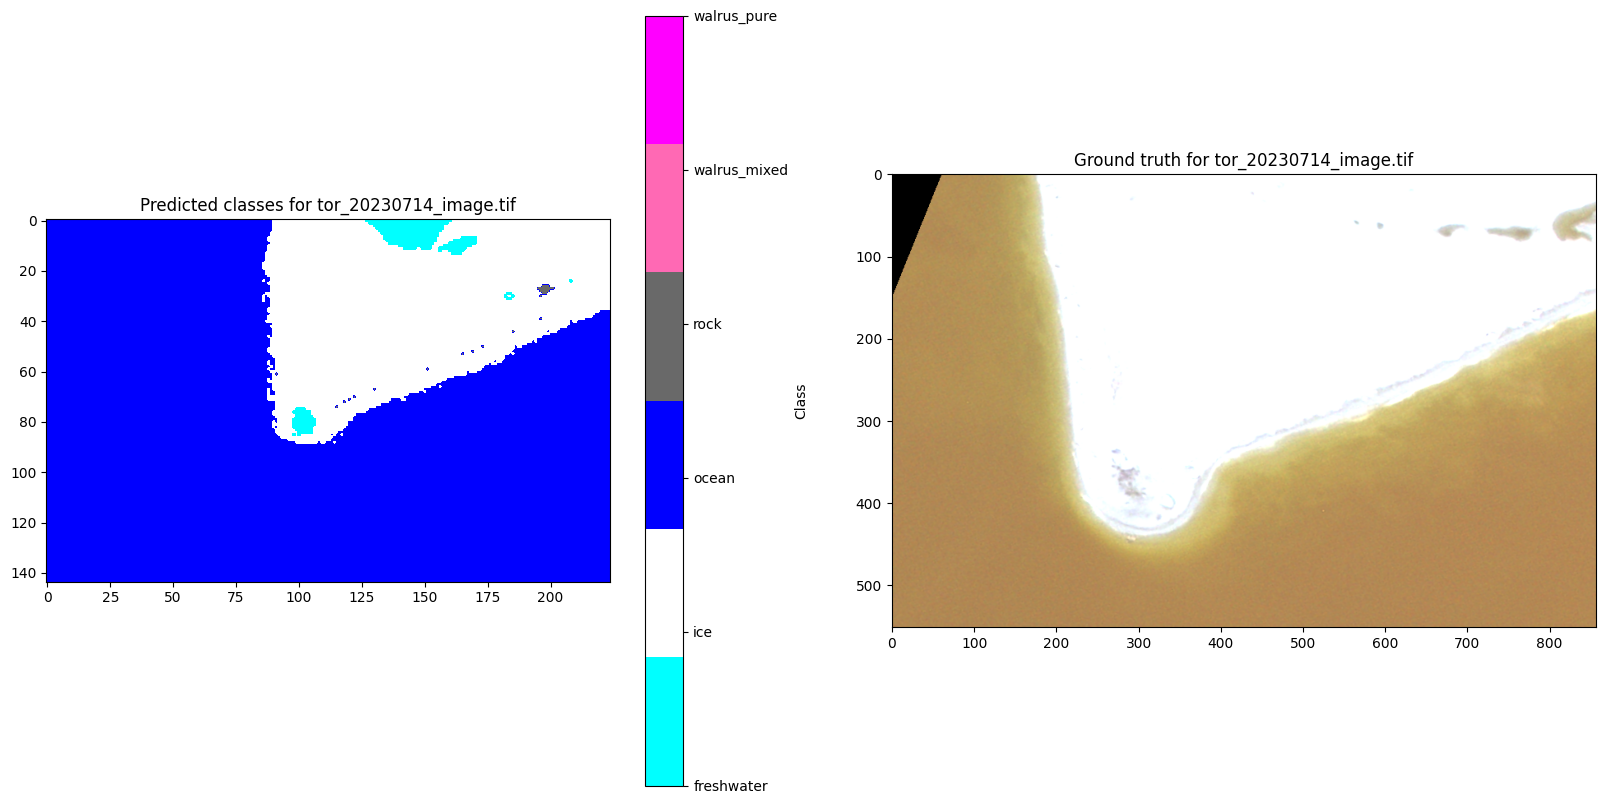

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


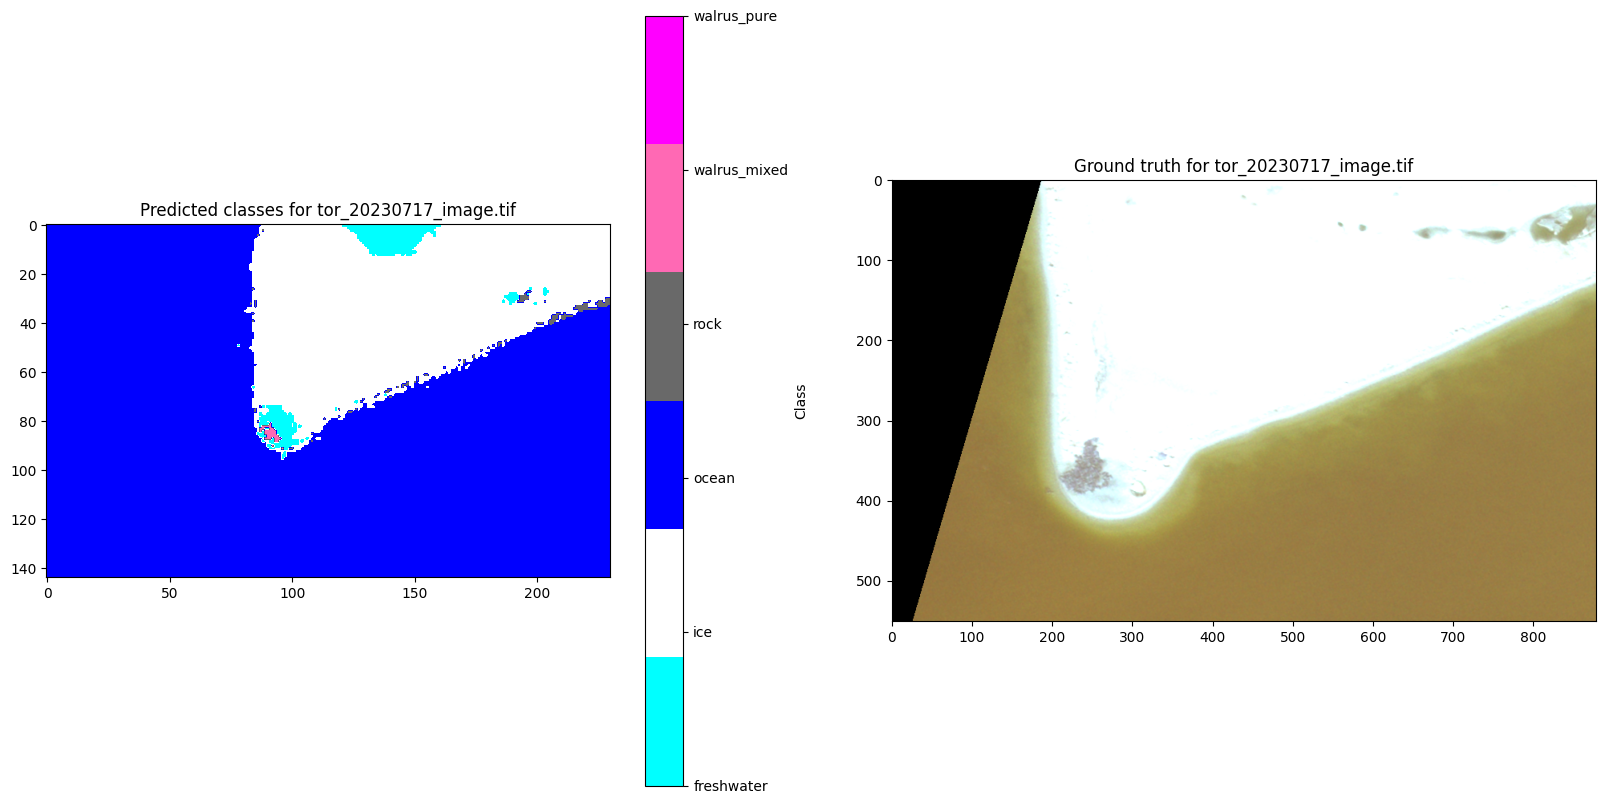

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


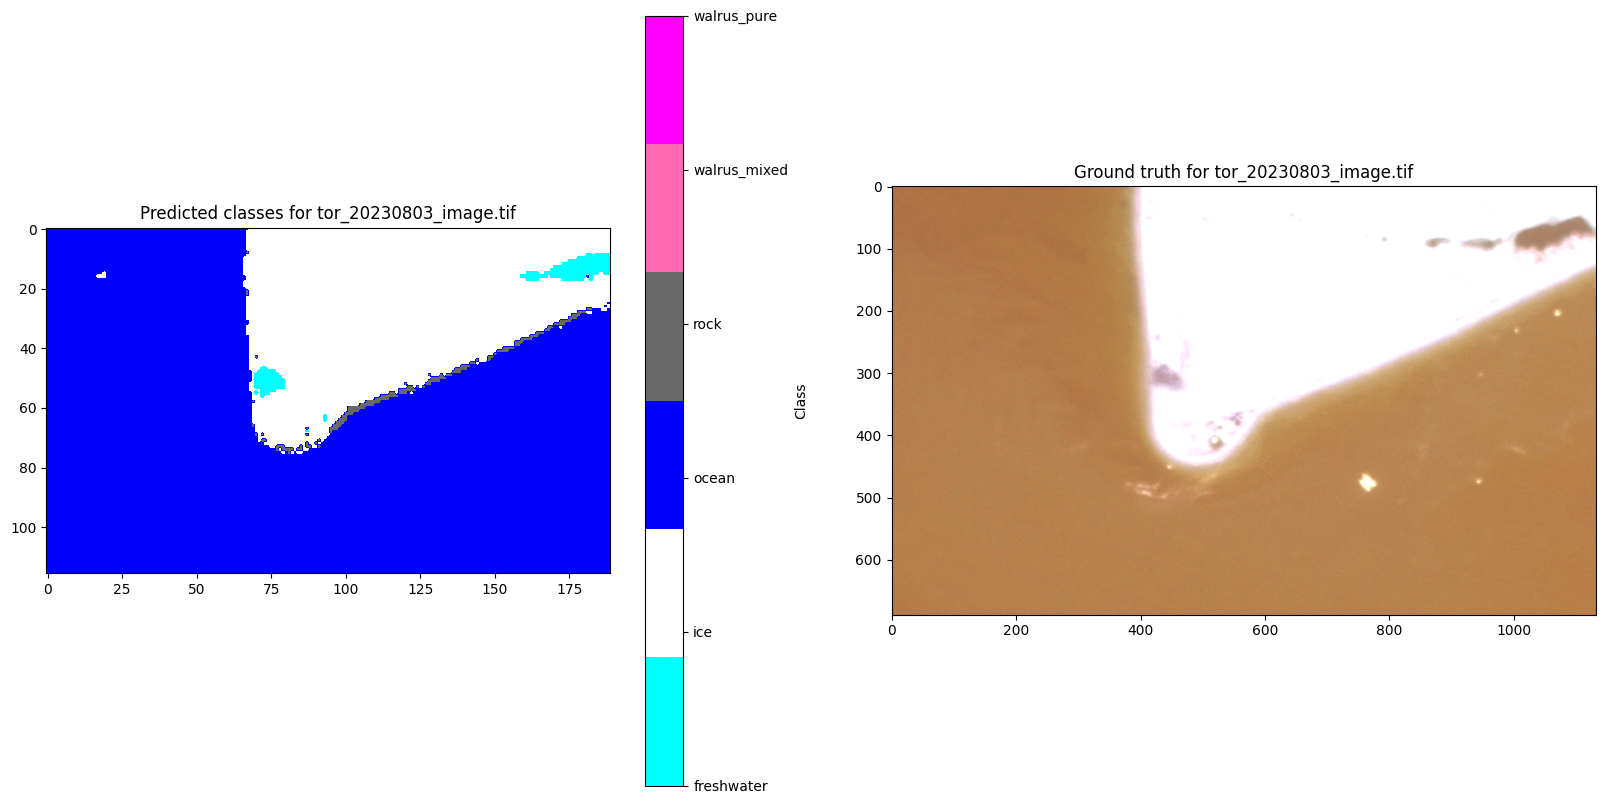

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


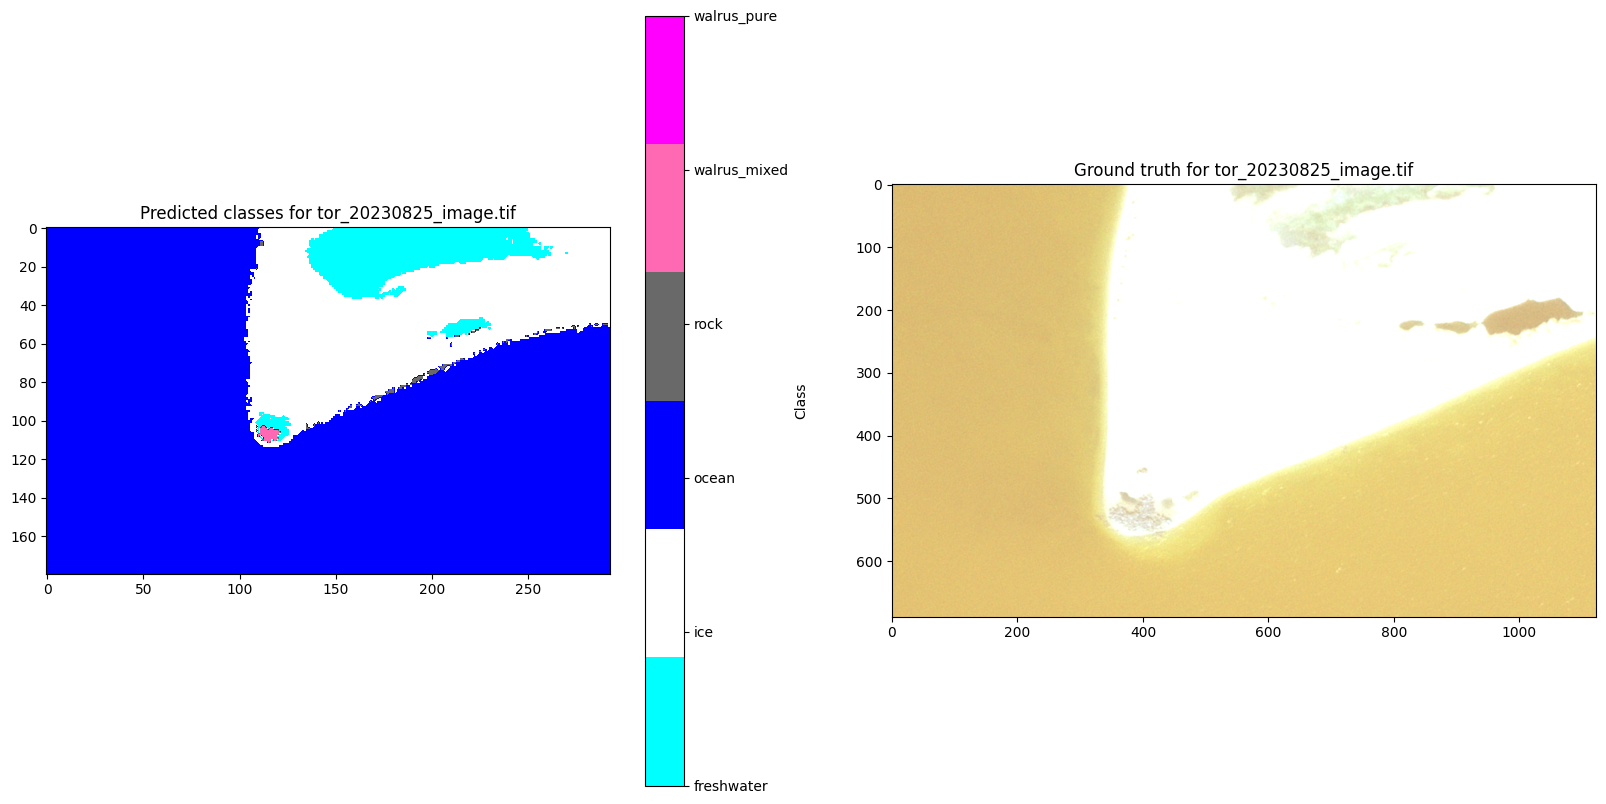

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


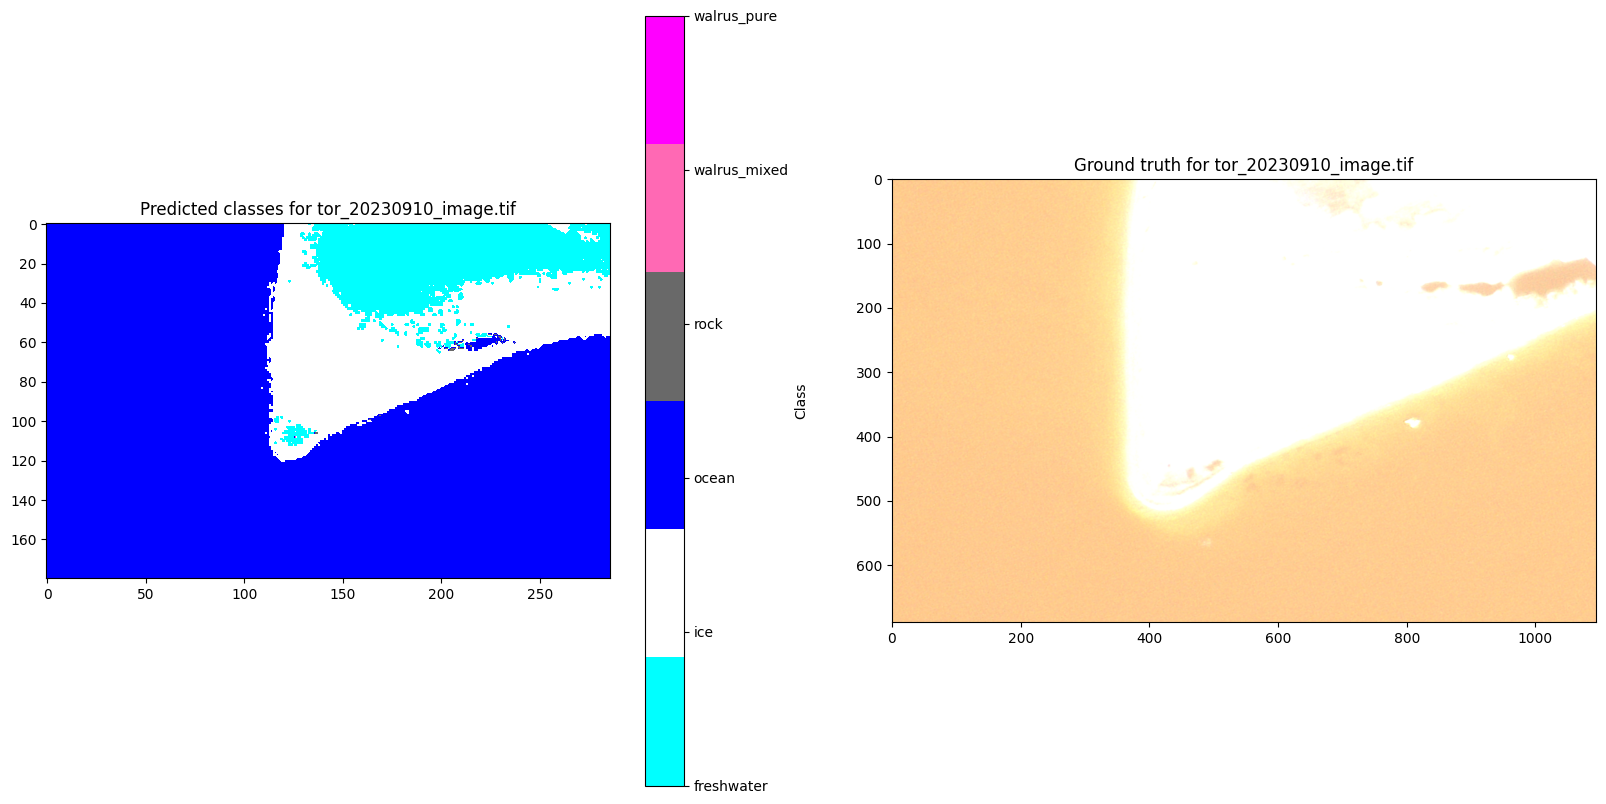

In [51]:
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    groundtruth_image_path = get_groundtruth_image_path(image_path)

    if not os.path.exists(groundtruth_image_path):
        print(f"Ground truth image not found for {os.path.basename(image_path)}")
        continue

    groundtruth_image = load_groundtruth_image(groundtruth_image_path)

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Plot predicted image
    axes[0].set_title(f"Predicted classes for {os.path.basename(image_path)}")
    im = axes[0].imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_) - 1)
    cbar = plt.colorbar(im, ax=axes[0], ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)

    # Plot ground truth image
    axes[1].set_title(f"Ground truth for {os.path.basename(image_path)}")
    # Make sure ground truth image is in the correct shape
    groundtruth_image_rgb = groundtruth_image[:3].transpose(1, 2, 0)
    axes[1].imshow(groundtruth_image_rgb)

    plt.show()